# How Much Has COVID-19 Slowed Census Enumeration In Rural Areas?
### By Benjamin Livingston, *[NewsCounts](https://newscounts.org/)*
### May 28, 2020

# Introduction

The [suspension of US Census Bureau operations](https://www.census.gov/newsroom/press-releases/2020/update-on-2020-census-field-operations.html) due to the COVID-19 pandemic has created vast disparities in census counts between rural and non-rural areas.

The vast majority of areas in the United States [receive invitations by mail](https://2020census.gov/en/ways-to-respond.html) to fill out the census online, by phone, or by mail, a process that requires no visit from a census worker (unless a household fails to respond and requires [a Non-Response Follow-Up](https://www.census.gov/programs-surveys/decennial-census/2020-census/planning-management/planning-docs/NRFU-detailed-op-plan.html)). This makes it easy for these "Self-Response" areas to participate in the census relatively normally, even without visits from census workers. 

However, areas without reliable mail service rely on door-to-door visits from census workers, who either enumerate the household themselves (referred to as "Update Enumerate (UE)" or "Remote Alaska (RA)", or leave a packet with a form/invitation for the household to respond with themselves (also known as "Update Leave (UL)").

A detailed map of these areas (can be found here)[https://gis-portal.data.census.gov/arcgis/apps/webappviewer/index.html?id=cbf242acb9f849f381090cf144715340].

Inevitably, the latter type of areas (and the rural states heavily stocked with them) have fallen far behind in census enumeration due to the pandemic - and there is no telling how much these disparities will be assuaged when in-person enumeration begins.

# Analysis

We will examine how wide these disparities are by comparing the response rates for tracts that rely heavily on in-person census operations with response rates for tracts that have largely received invitations by mail.

First, we will import the data, and then we will visualize the trends.



In [174]:
# import packages and establish settings
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import warnings
from matplotlib.ticker import MaxNLocator
from IPython.display import HTML
%matplotlib inline
warnings.filterwarnings('ignore')

# set API key 
key = '2988f01f5e86175bda8beae2b5035e1ccef2d052'

# tested shortcut for obtaining state FIPS codes
url = f"https://api.census.gov/data/2010/dec/responserate?get=GEO_ID,FSRR2010&key={key}&for=state:*"
JSONContent = requests.get(url).json()
states = pd.DataFrame(JSONContent)
states = states.iloc[1:,2]
states = [int(i) for i in states if i !='72']
states = sorted(states)

# data frame to hold tract responses
tract_responses = pd.DataFrame(columns=['GEO_ID','CRRALL'])

# pull tract response data for 2020
for i in states:
    if i < 10:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL&key={key}&for=tract:*&in=state:0"\
        + str(i)
    else:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL&key={key}&for=tract:*&in=state:"\
        + str(i)
    try:
        JSONContent = requests.get(url).json()
        temp = pd.DataFrame(JSONContent)
        temp.columns = temp.iloc[0]
        temp = temp.iloc[1:,:]
        tract_responses = pd.concat([tract_responses,temp],sort=True)
    except json.JSONDecodeError:
        pass

# set index and column title for 2020 response rates
tract_responses['CRRALL'] = tract_responses['CRRALL'].astype('float')
tract_responses.index = tract_responses.GEO_ID.str.replace('1400000US','')
tract_responses = tract_responses.drop(columns = 'GEO_ID')
tract_responses.columns = ['response','county','state','tract']

# pull type of enumeration data
tea = pd.read_excel('https://www2.census.gov/geo/maps/DC2020/TEA/TEA_PCT_Housing_Tract.xlsx')
tea.index = tea.TRACT_GEOID
tea.index.name = 'GEO_ID'
tea.index = tea.index.astype('str').str.zfill(11)
tea['inperson'] = tea.PCT_HU_TEA2 + tea.PCT_HU_TEA4 + tea.PCT_HU_TEA6
tea = tea.drop(columns=['TRACT_GEOID','PCT_HU_TEA2','PCT_HU_TEA3','PCT_HU_TEA4','PCT_HU_TEA6'])
tea.columns=['mail','inperson']

# remove type of enumeration entries with no data
tea = tea[np.sum(tea,axis=1) > 99.5]

# count percentage of tracts in our response dataset for which we have enumeration data
temp = pd.merge(tract_responses,tea,'left','GEO_ID')
print(np.round(100 * np.sum(pd.notnull(temp.mail)) / temp.shape[0],1),'% of tracts with response rate data \
also have enumeration strategy logged and will be a part of this analysis',sep='')

# create dataset
data = pd.merge(tract_responses,tea,'inner','GEO_ID')


73.3% of tracts with response rate data also have enumeration strategy logged and will be a part of this analysis


With the data imported, we see that approximately three-quarters of the tracts with response rate data also have enumeration strategies logged. Thus, these will be the tracts we use for our analysis.

We start by examining the basic linear [correlation](https://bwliv.github.io/undercount_modeling#Mathematical-Nuts-&amp;-Bolts) between the amount of a tract receiving 

In [175]:
# show correlations
corrs = pd.DataFrame(data.corr().iloc[1:,0].round(2))
corrs.columns = ['Correlation With Overall Response Rates']
corrs.index = ['Presence Of Areas In Tract Receiving Mail Invitations For Initial Contact',\
       'Presences of Areas In Tract Relying On In-Person Census Operations For Initial Contact']
display(corrs)


Correlation With Overall Response Rates
Tracts Not Relying On In-Person Census Operatio...                                     0.52
Tracts Relying On In-Person Census Operations F...                                    -0.52

Text(0, 0.5, 'Response Rate For Tract (%)')

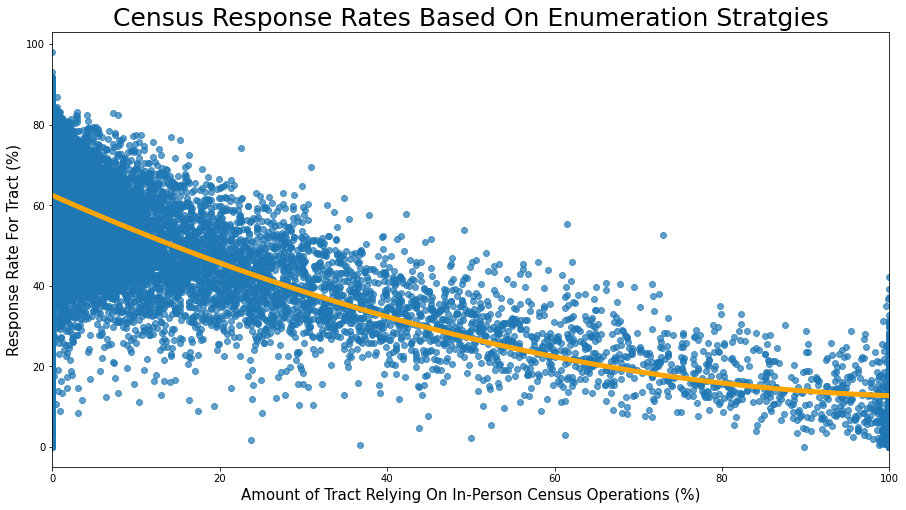

In [176]:
# make scatterplot of data
plt.figure(figsize=(15,8))
plt.scatter(data.inperson,data.response,alpha=0.7,label='Areas Relying Heavily On In-Person Operations')
plt.plot(np.unique(data.inperson),np.poly1d(np.polyfit(data.inperson,data.response, 2))(np.unique(data.inperson)),\
         c='orange',linewidth=5)
plt.title('Census Response Rates Based On Enumeration Stratgies',size=25)
plt.xlim(0,100)
plt.xlabel('Amount of Tract Relying On In-Person Census Operations (%)',size=15)
plt.ylabel('Response Rate For Tract (%)',size=15)


Text(0.5, 1.0, 'Tracts Relying Exclusively On In-Person Census Operations For Initial Contact')

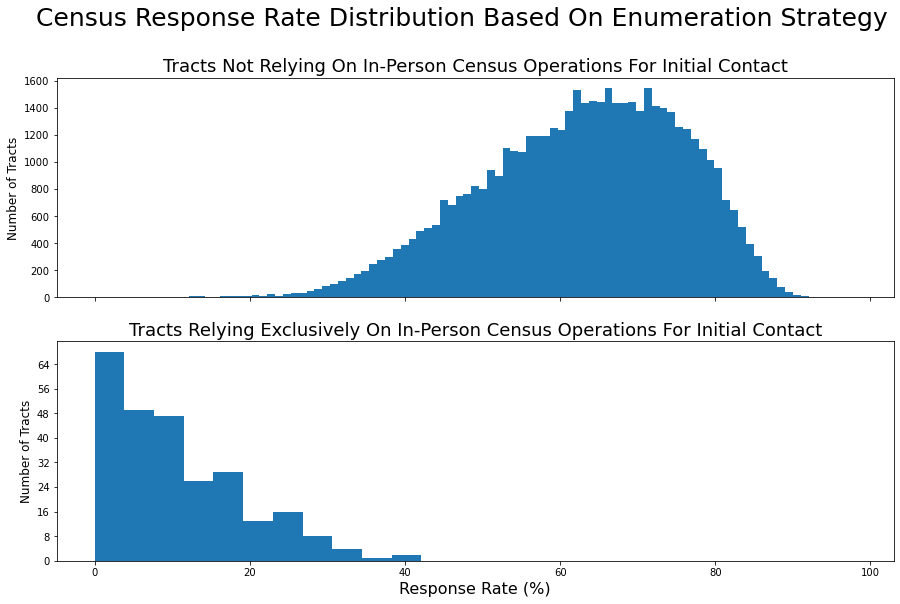

In [177]:
# make histograms of data
all_mail = data[data.inperson == 0]
all_inperson = data[data.mail == 0]
fig,ax = plt.subplots(2,1,figsize=(15,9),sharex=True)
plt.xlabel('Response Rate (%)',size=16)
plt.subplots_adjust(top=0.87)
plt.suptitle('Census Response Rate Distribution Based On Enumeration Strategy',size=25)
mai = ax[0]
inp = ax[1]
mai.yaxis.set_major_locator(MaxNLocator(integer=True))
inp.yaxis.set_major_locator(MaxNLocator(integer=True))
mai.set_ylabel('Number of Tracts',size=12)
inp.set_ylabel('Number of Tracts',size=12)
mai.hist(all_mail.response,bins='auto')
inp.hist(all_inperson.response,bins='auto')
mai.set_title('Tracts Not Relying On In-Person Census Operations For Initial Contact',size=18)
inp.set_title('Tracts Relying Exclusively On In-Person Census Operations For Initial Contact',size=18)


# State Case Studies

We will now conduct this analysis for each of the fifty states, plus the District of Columbia.

Some of these states rely heavily on in-person enumeration (and thus will provide robust data), while some barely depend on it. The former category of state is more interesting to us, but we will show all of them in alphabetical order for the sake of being thorough.

Keep in mind - **we can easily do this analysis for a smaller region almost instantly** - email me any time at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) if you'd like to see these results for your region, too.

[*NewsCounts*](http://newscounts.org) provides countless data & research resources that make telling these stories easy - just drop us a line and we'll be happy to help.


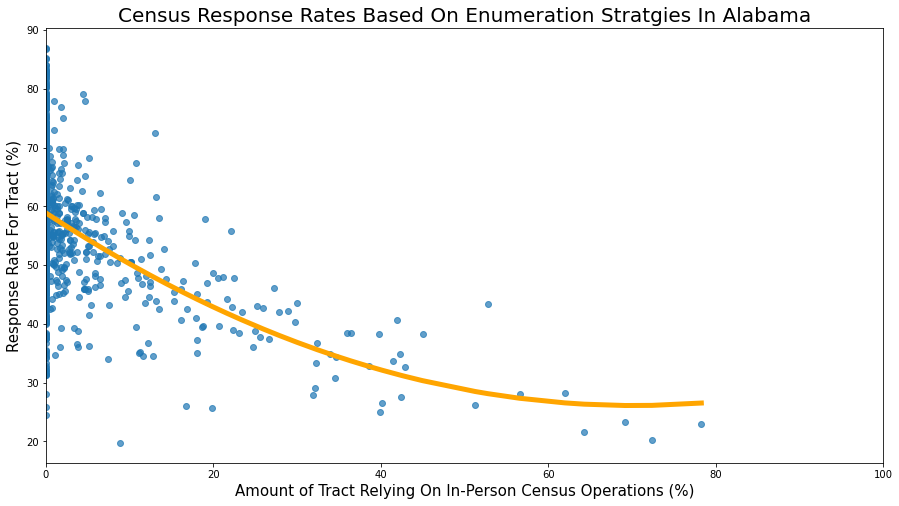

Correlation With Overall Response Rates In Alabama
Tracts Not Relying On In-Person Census Operatio...                                               0.49 
Tracts Relying On In-Person Census Operations F...                                              -0.49

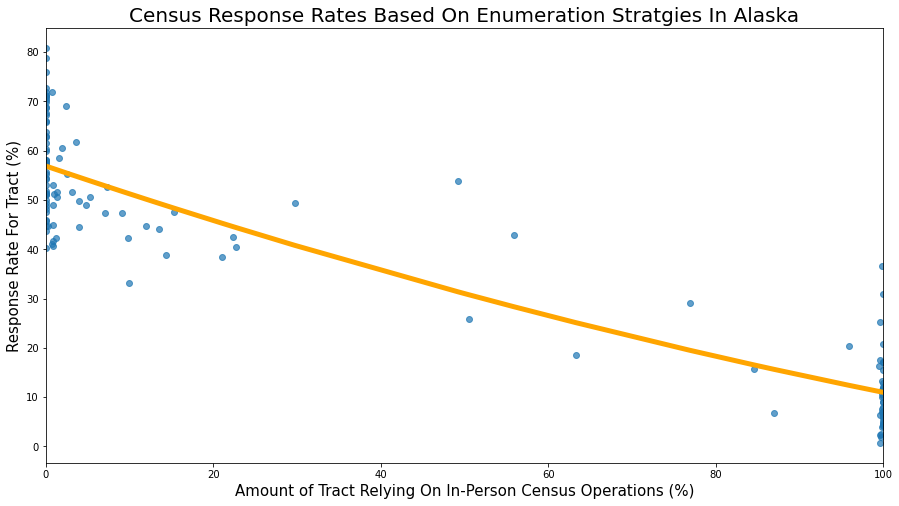

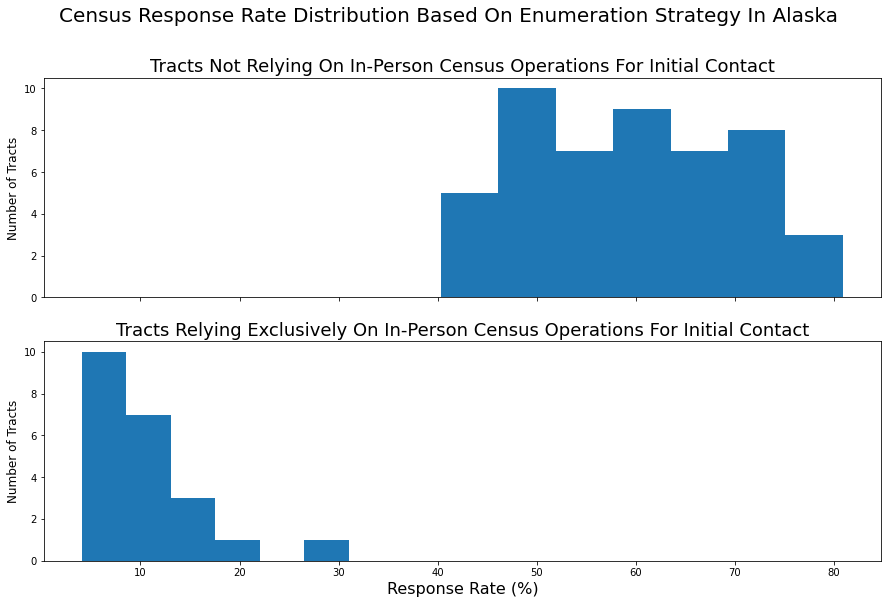

Correlation With Overall Response Rates In Alaska
Tracts Not Relying On In-Person Census Operatio...                                               0.91
Tracts Relying On In-Person Census Operations F...                                              -0.91

02013000100
02016000200
02020002900
02050000200
02070000200
02122000300
02122001200
02122001300
02170000501
02170000502
02170001300
02180000200
02185000100
02188000200
02195000200
02198000100
02198000200
02198940100
02220000100
02240000400
02275000300
02282000100




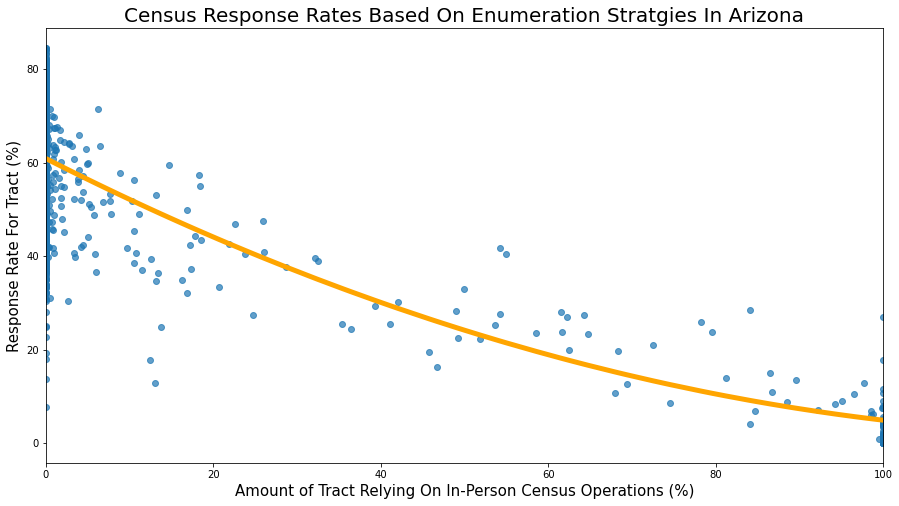

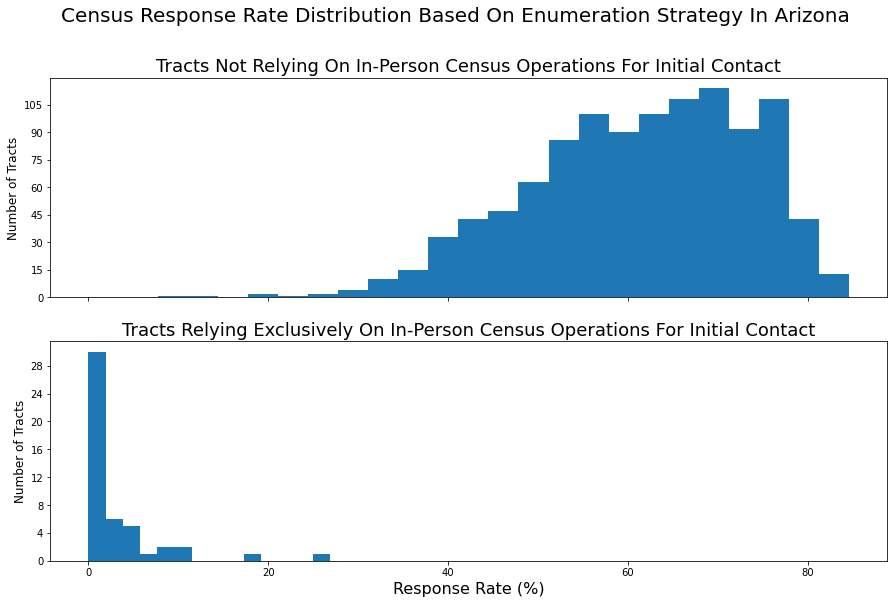

Correlation With Overall Response Rates In Arizona
Tracts Not Relying On In-Person Census Operatio...                                               0.75 
Tracts Relying On In-Person Census Operations F...                                              -0.75

04001942600
04001942700
04001944000
04001944100
04001944201
04001944202
04001944901
04001944902
04001945001
04001945002
04001945100
04005942201
04005942202
04005944900
04005945000
04005945100
04005945200
04007940200
04007940400
04009940500
04012940200
04012940300
04013940700
04013941000
04013941100
04015940400
04017940008
04017940010
04017940011
04017940012
04017940013
04017940014
04017940015
04017940100
04017940301
04017940302
04017942300
04017942400
04017942500
04017963700
04017964201
04019940800
04019940900
04021941200
04025001300
04025002100
04027011403
04027011405




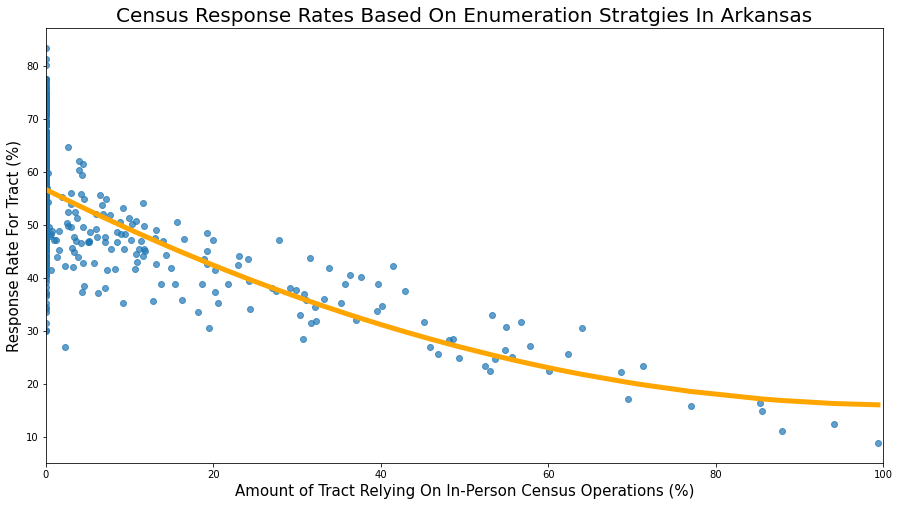

Correlation With Overall Response Rates In Arkansas
Tracts Not Relying On In-Person Census Operatio...                                               0.68  
Tracts Relying On In-Person Census Operations F...                                              -0.68

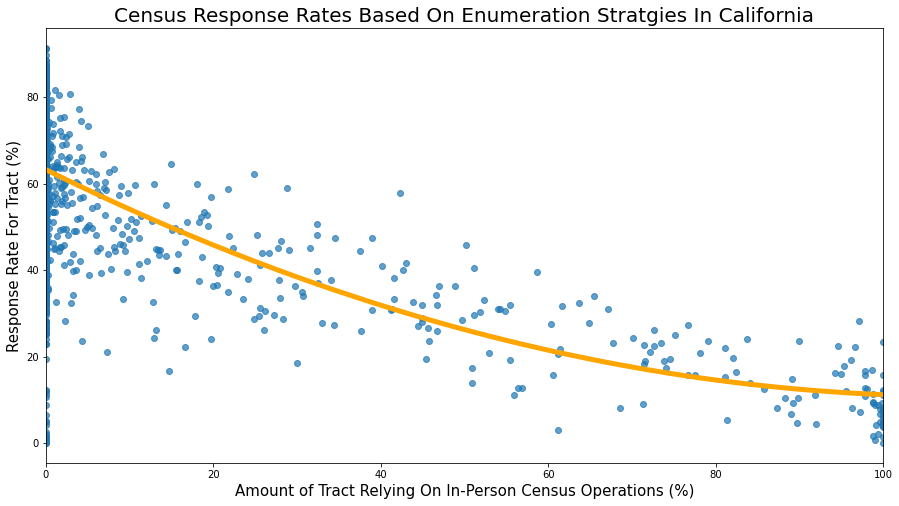

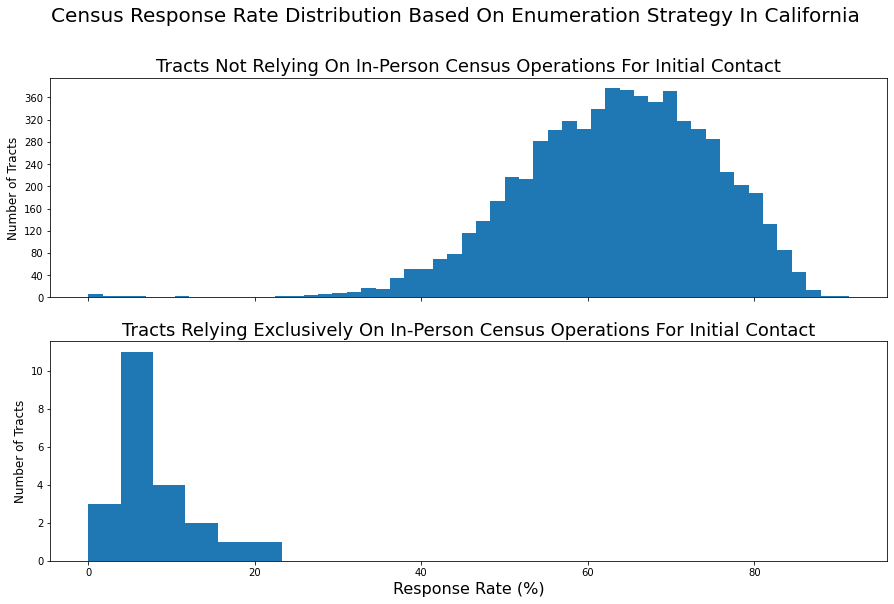

Correlation With Overall Response Rates In California
Tracts Not Relying On In-Person Census Operatio...                                                0.5    
Tracts Relying On In-Person Census Operations F...                                               -0.5

06007001800
06007001900
06007002000
06023940000
06037599000
06037599100
06041113000
06041122000
06059099506
06061020105
06061020106
06061020107
06061022100
06071009201
06071010803
06071010804
06071011203
06071011204
06071011205
06071011206
06071940100
06083980100




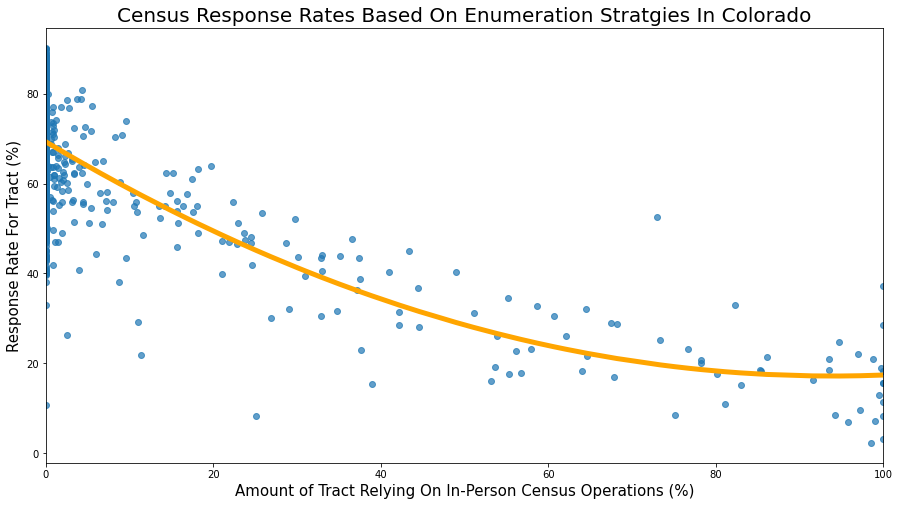

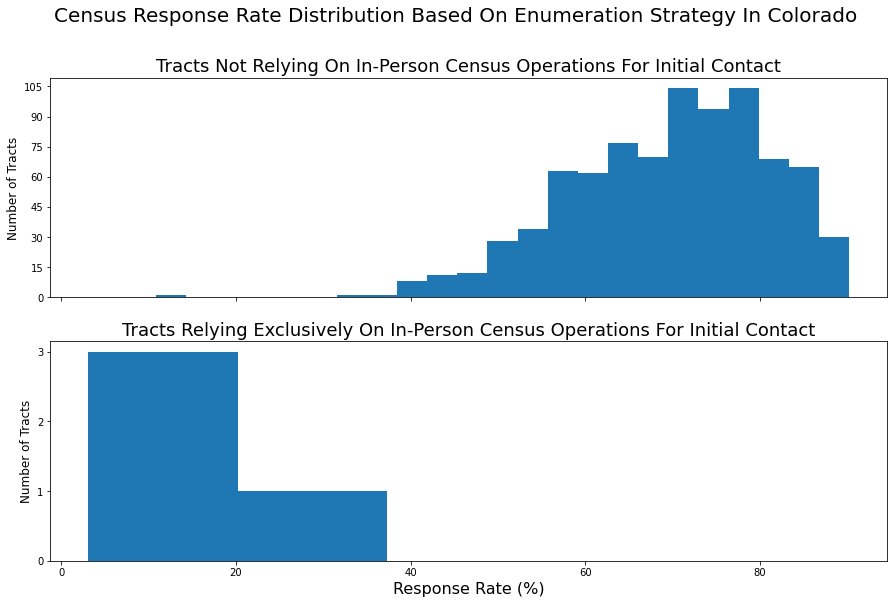

Correlation With Overall Response Rates In Colorado
Tracts Not Relying On In-Person Census Operatio...                                               0.72  
Tracts Relying On In-Person Census Operations F...                                              -0.72

08007940400
08037000501
08037000502
08037000600
08067940300
08067940400
08107000200
08113968101




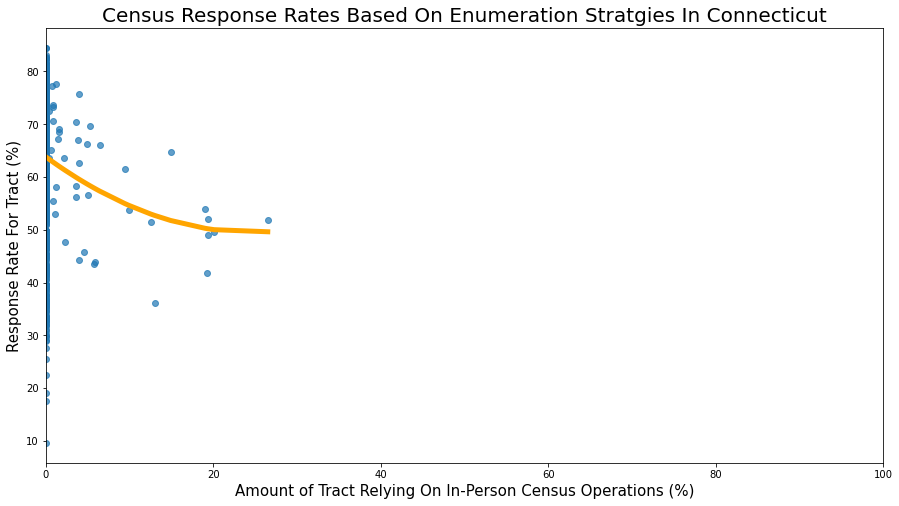

Correlation With Overall Response Rates In Connecticut
Tracts Not Relying On In-Person Census Operatio...                                               0.12     
Tracts Relying On In-Person Census Operations F...                                              -0.12

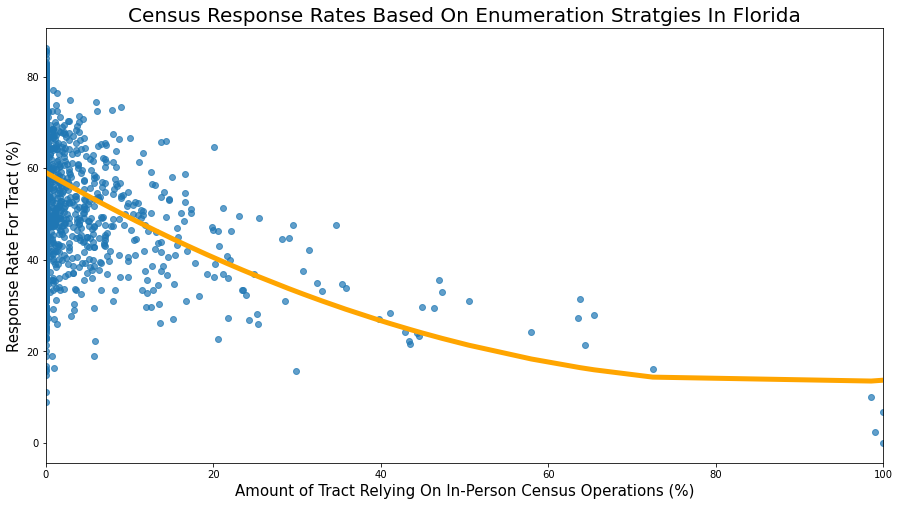

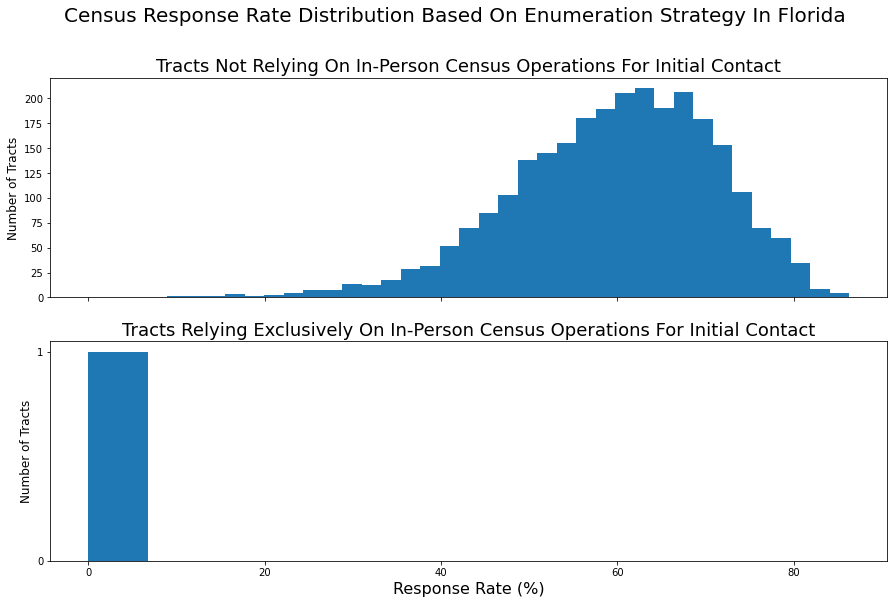

Correlation With Overall Response Rates In Florida
Tracts Not Relying On In-Person Census Operatio...                                               0.36 
Tracts Relying On In-Person Census Operations F...                                              -0.36

12005000600
12005000700




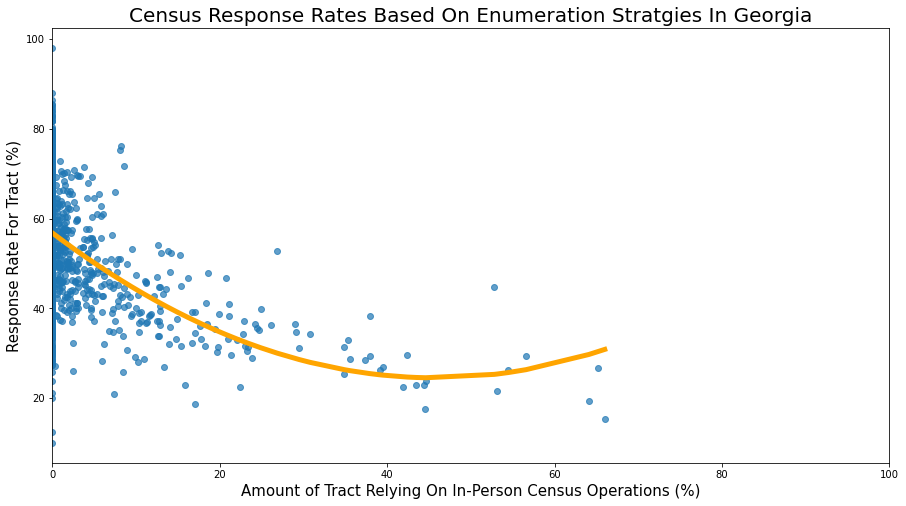

Correlation With Overall Response Rates In Georgia
Tracts Not Relying On In-Person Census Operatio...                                               0.45 
Tracts Relying On In-Person Census Operations F...                                              -0.45

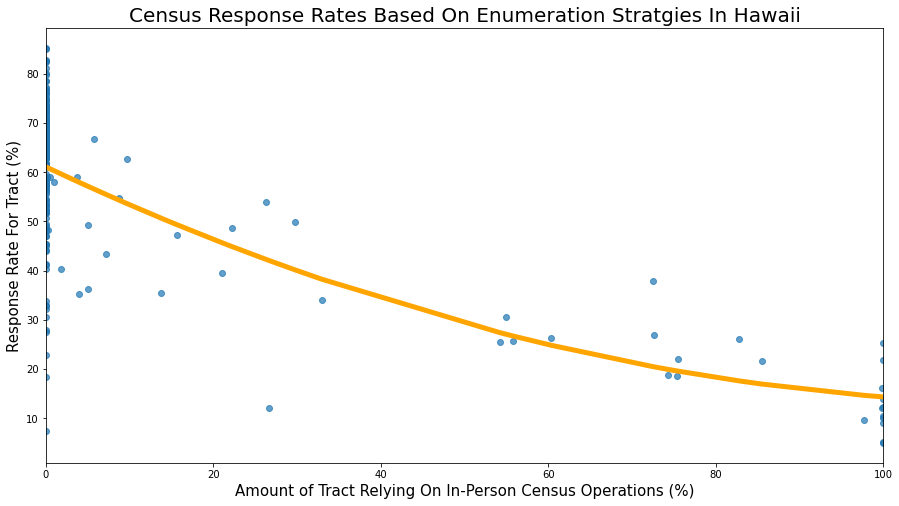

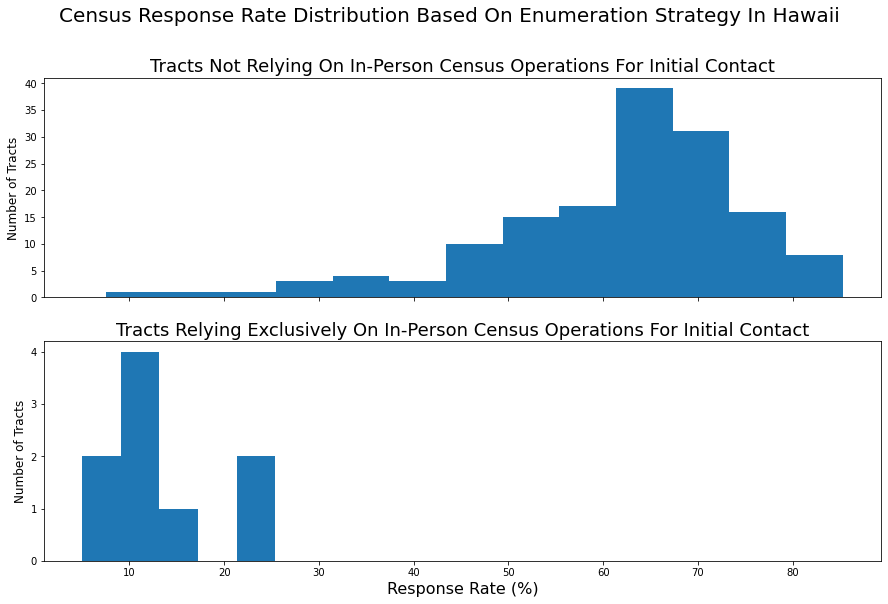

Correlation With Overall Response Rates In Hawaii
Tracts Not Relying On In-Person Census Operatio...                                               0.73
Tracts Relying On In-Person Census Operations F...                                              -0.73

15001021003
15001021011
15001022102
15005031900
15007040104
15007040800
15007040900
15009031700
15009031801




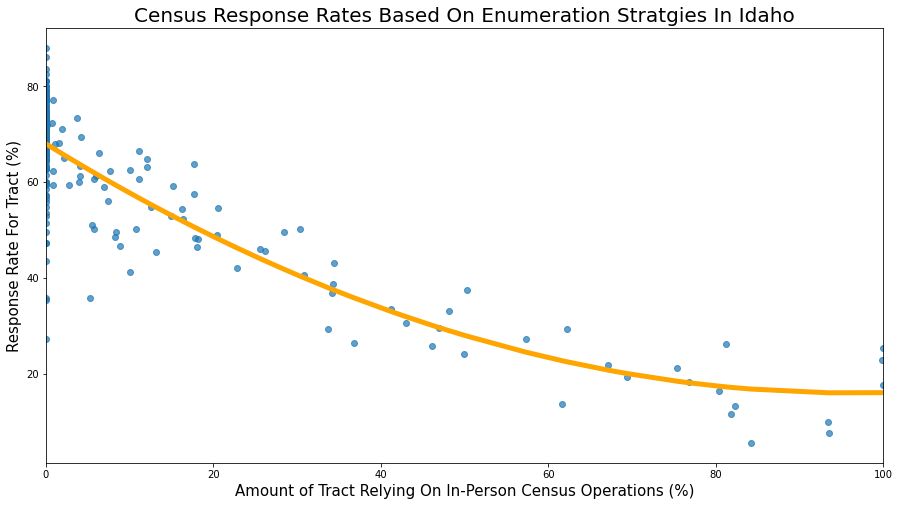

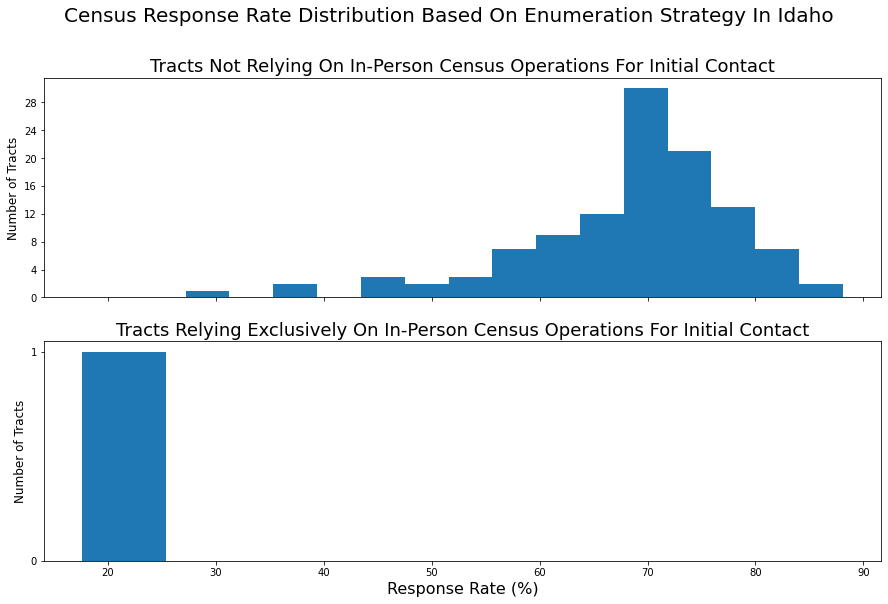

Correlation With Overall Response Rates In Idaho
Tracts Not Relying On In-Person Census Operatio...                                              0.85
Tracts Relying On In-Person Census Operations F...                                             -0.85

16005940000
16011940000




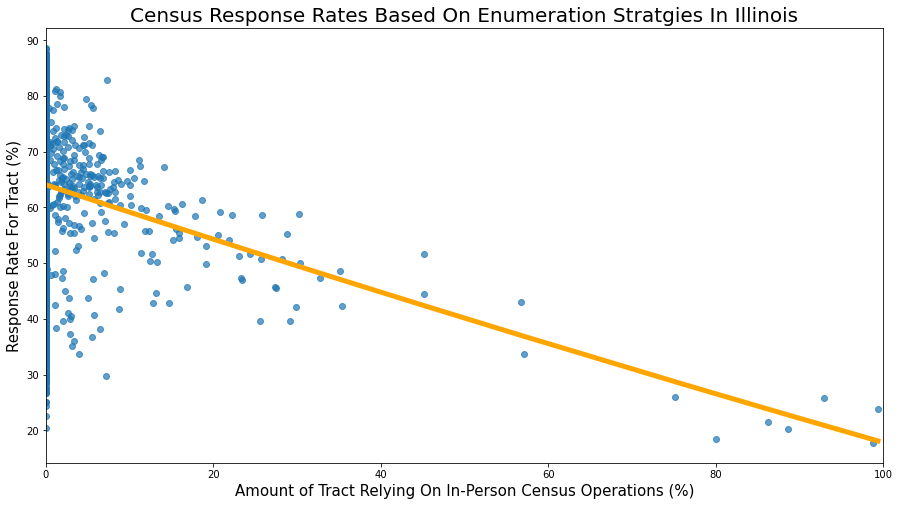

Correlation With Overall Response Rates In Illinois
Tracts Not Relying On In-Person Census Operatio...                                               0.19  
Tracts Relying On In-Person Census Operations F...                                              -0.19

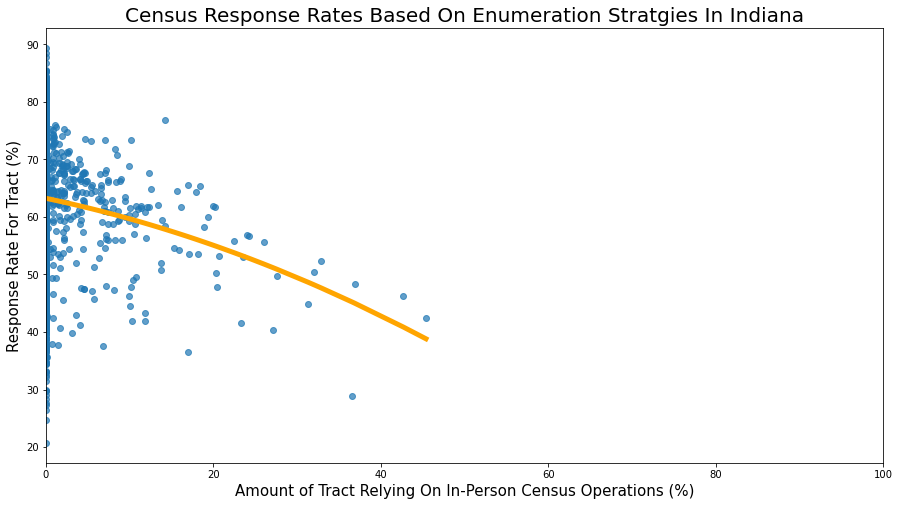

Correlation With Overall Response Rates In Indiana
Tracts Not Relying On In-Person Census Operatio...                                               0.16 
Tracts Relying On In-Person Census Operations F...                                              -0.16

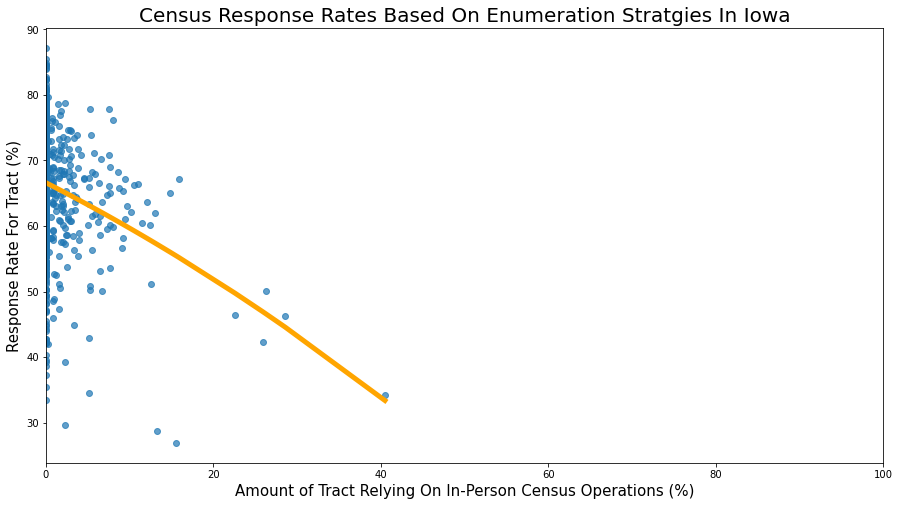

Correlation With Overall Response Rates In Iowa
Tracts Not Relying On In-Person Census Operatio...                                             0.27
Tracts Relying On In-Person Census Operations F...                                            -0.27

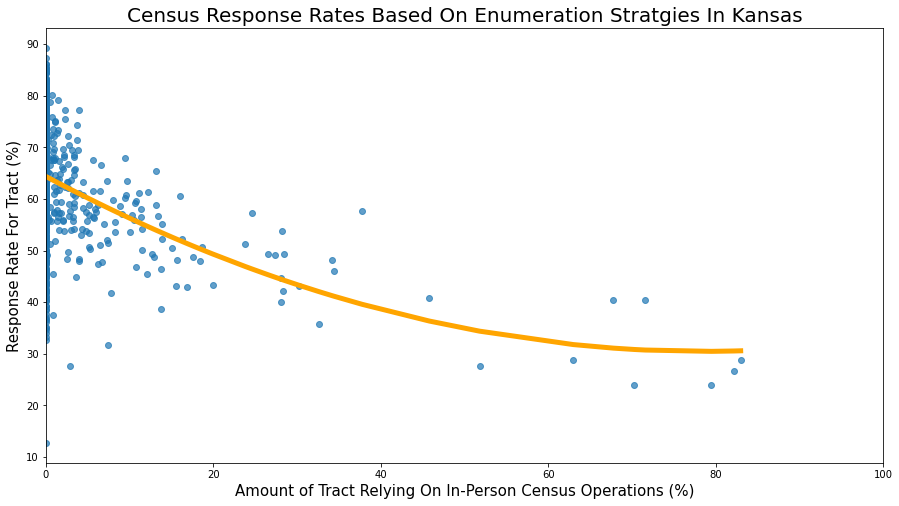

Correlation With Overall Response Rates In Kansas
Tracts Not Relying On In-Person Census Operatio...                                               0.41
Tracts Relying On In-Person Census Operations F...                                              -0.41

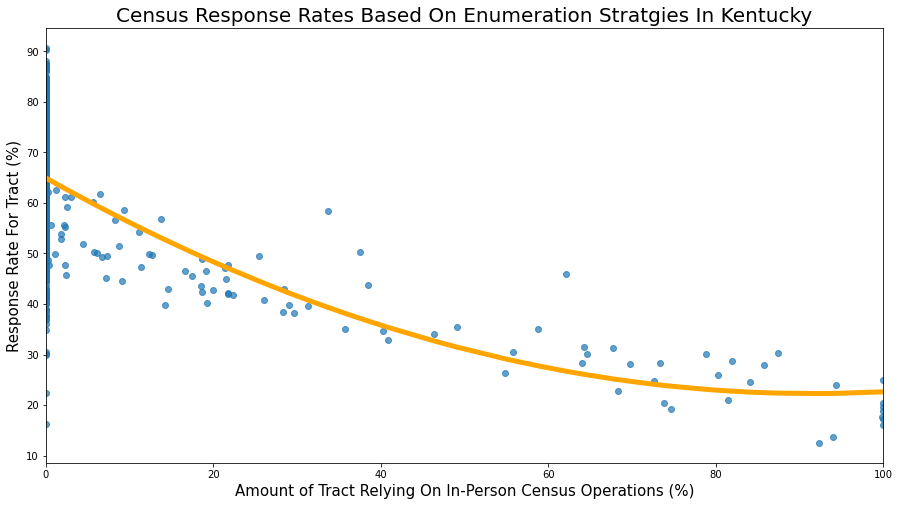

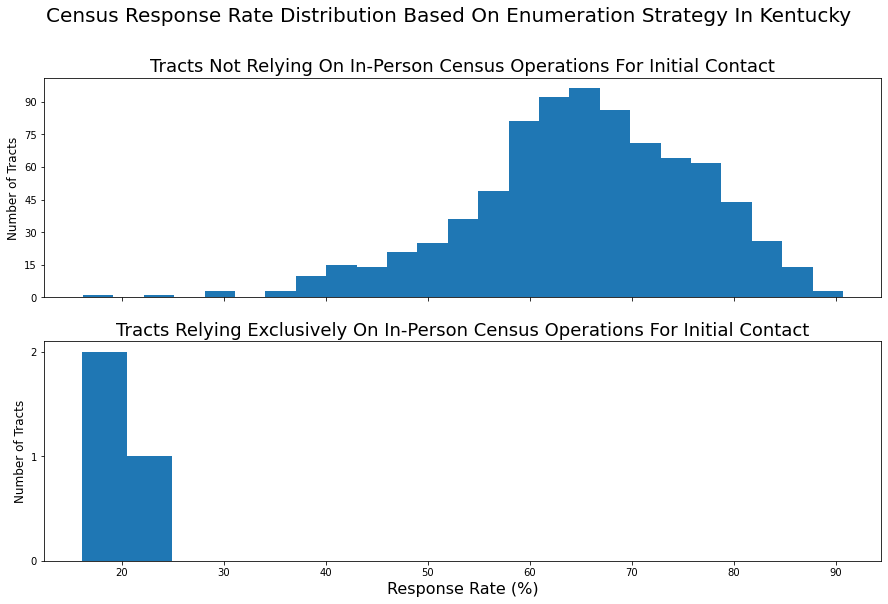

Correlation With Overall Response Rates In Kentucky
Tracts Not Relying On In-Person Census Operatio...                                                0.6  
Tracts Relying On In-Person Census Operations F...                                               -0.6

21095970600
21121930602
21131920200
21131920300
21189930100
21189930200




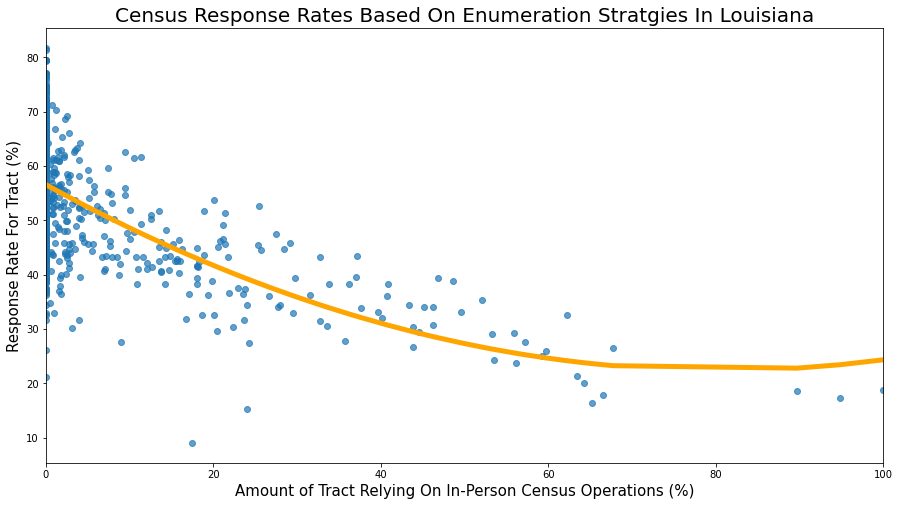

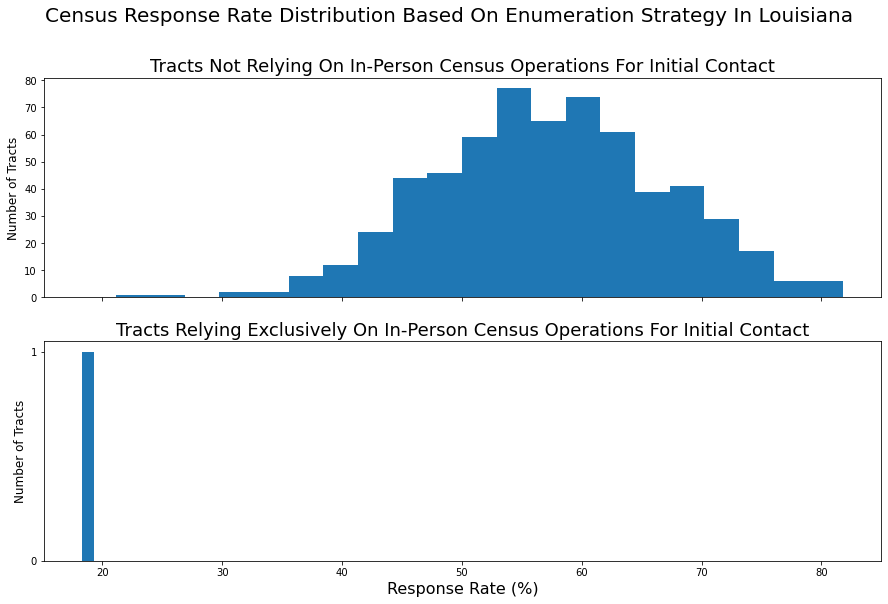

Correlation With Overall Response Rates In Louisiana
Tracts Not Relying On In-Person Census Operatio...                                               0.59   
Tracts Relying On In-Person Census Operations F...                                              -0.59

22071004800




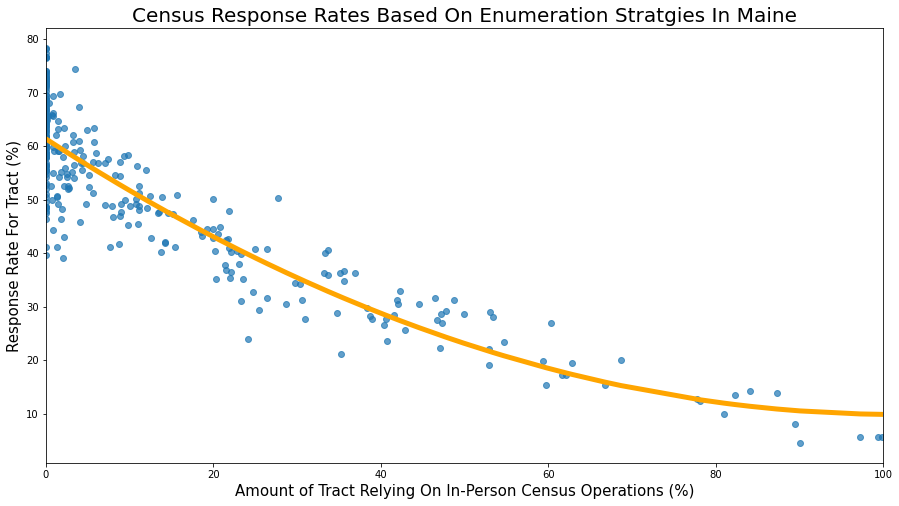

Correlation With Overall Response Rates In Maine
Tracts Not Relying On In-Person Census Operatio...                                              0.89
Tracts Relying On In-Person Census Operations F...                                             -0.89

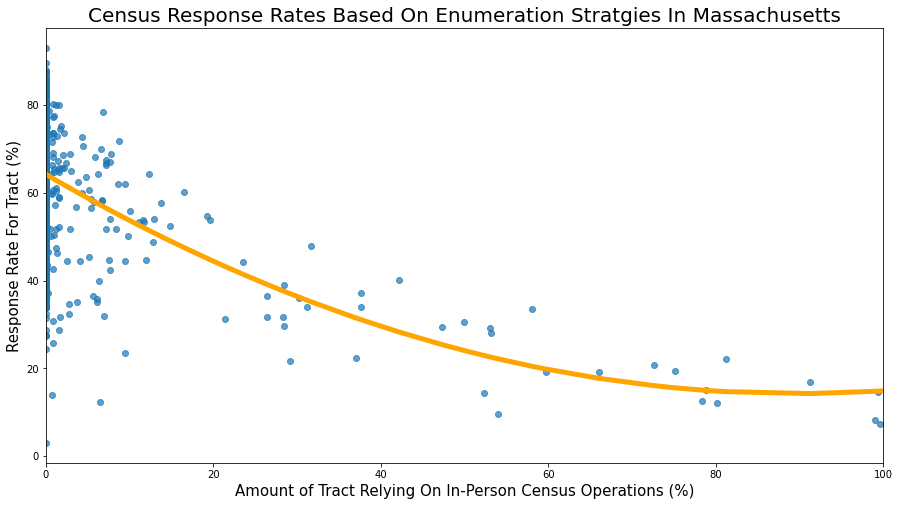

Correlation With Overall Response Rates In Massachusetts
Tracts Not Relying On In-Person Census Operatio...                                               0.43       
Tracts Relying On In-Person Census Operations F...                                              -0.43

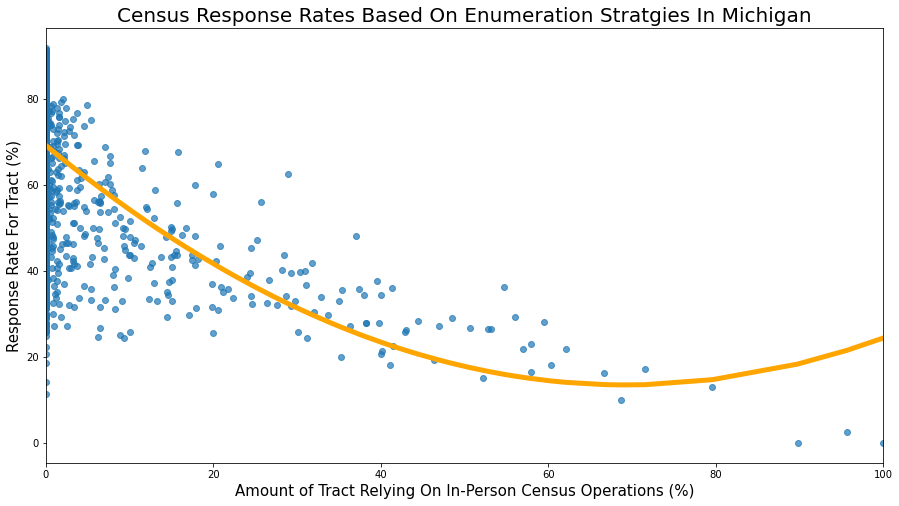

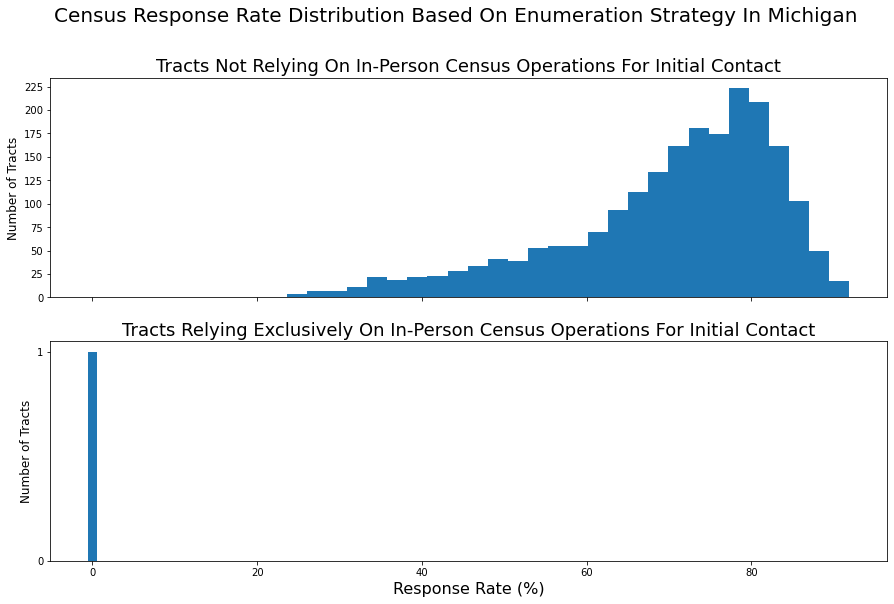

Correlation With Overall Response Rates In Michigan
Tracts Not Relying On In-Person Census Operatio...                                               0.49  
Tracts Relying On In-Person Census Operations F...                                              -0.49

26099982100




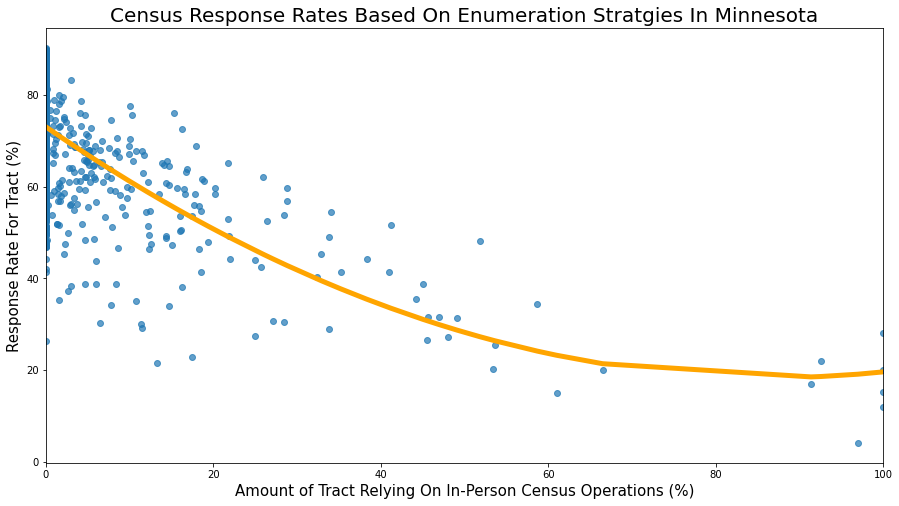

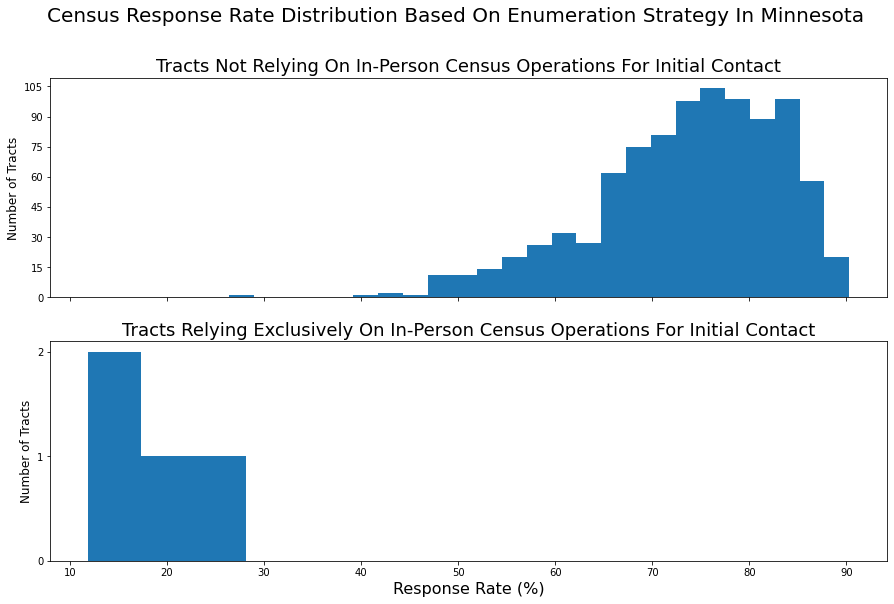

Correlation With Overall Response Rates In Minnesota
Tracts Not Relying On In-Person Census Operatio...                                               0.61   
Tracts Relying On In-Person Census Operations F...                                              -0.61

27021940002
27061940000
27087940100
27087940300




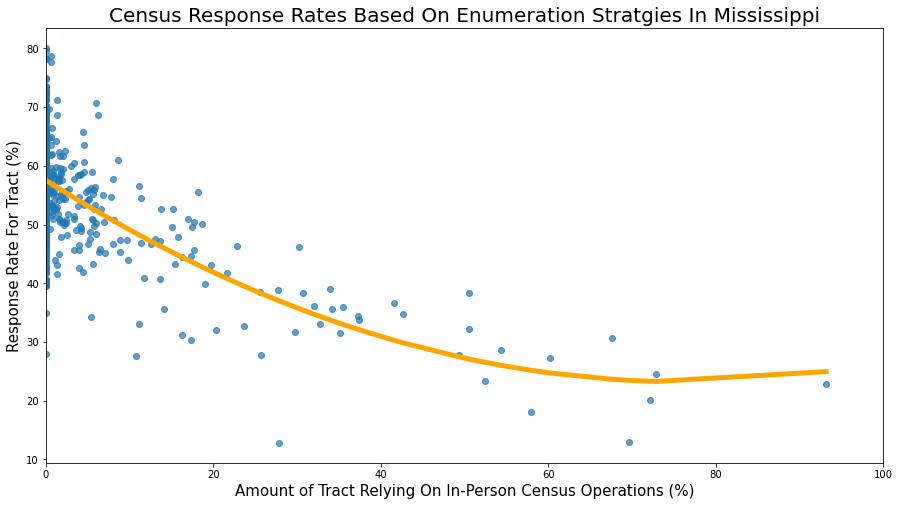

Correlation With Overall Response Rates In Mississippi
Tracts Not Relying On In-Person Census Operatio...                                               0.64     
Tracts Relying On In-Person Census Operations F...                                              -0.64

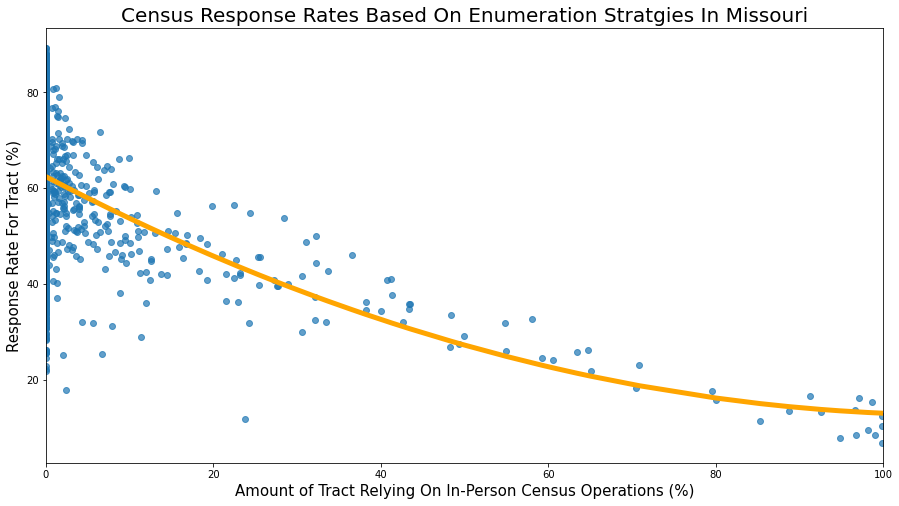

Correlation With Overall Response Rates In Missouri
Tracts Not Relying On In-Person Census Operatio...                                               0.53  
Tracts Relying On In-Person Census Operations F...                                              -0.53

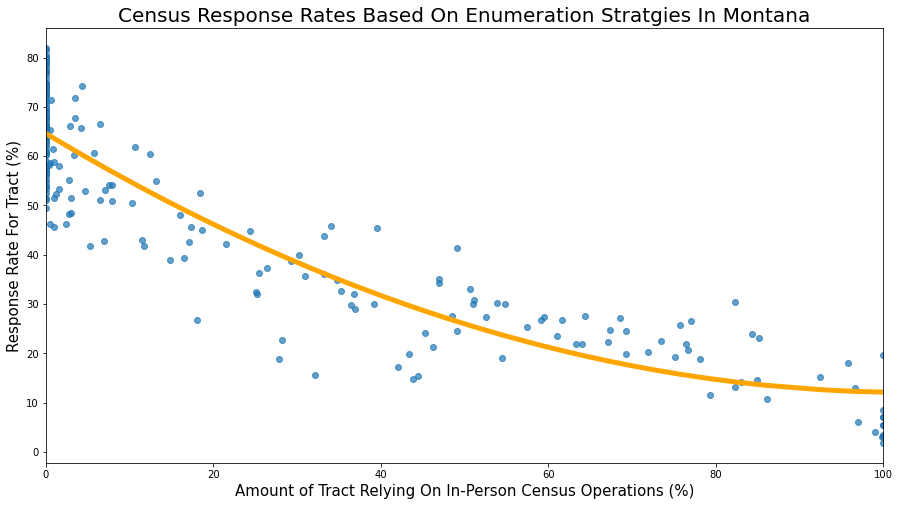

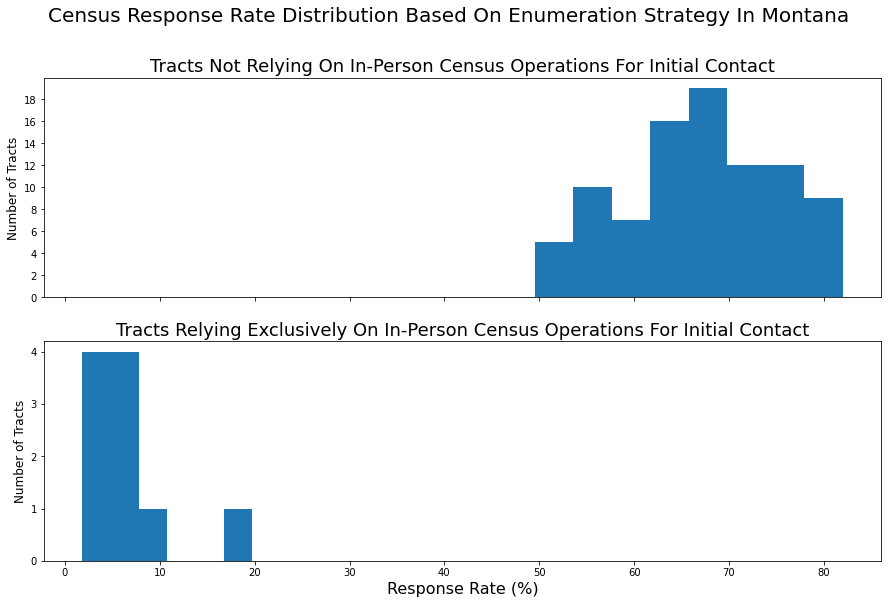

Correlation With Overall Response Rates In Montana
Tracts Not Relying On In-Person Census Operatio...                                                0.9 
Tracts Relying On In-Person Census Operations F...                                               -0.9

30003940600
30003940700
30005940100
30005940200
30035940200
30035940400
30035980000
30085940001
30085940002
30087940400




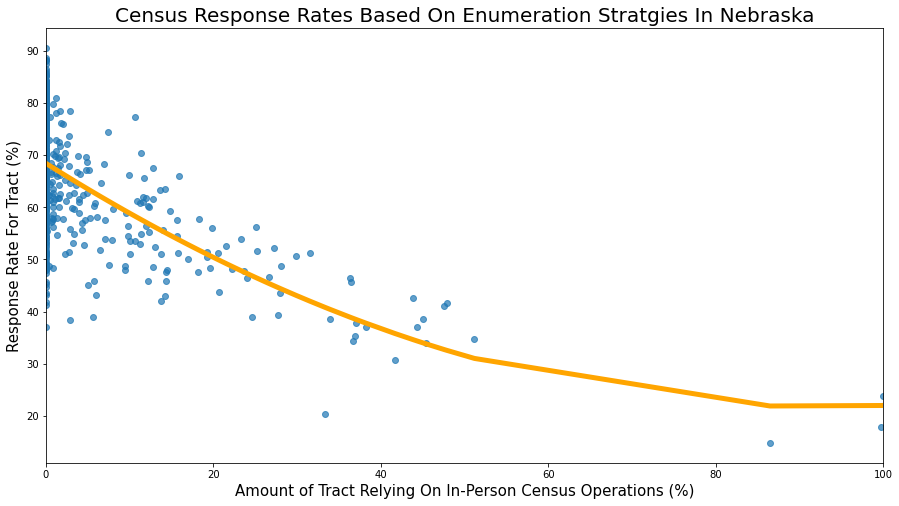

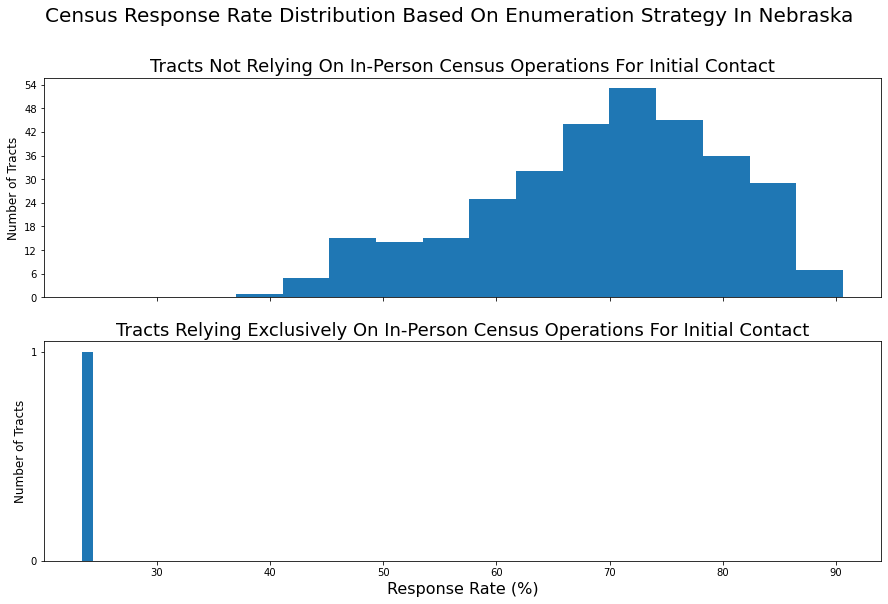

Correlation With Overall Response Rates In Nebraska
Tracts Not Relying On In-Person Census Operatio...                                               0.61  
Tracts Relying On In-Person Census Operations F...                                              -0.61

31173940100




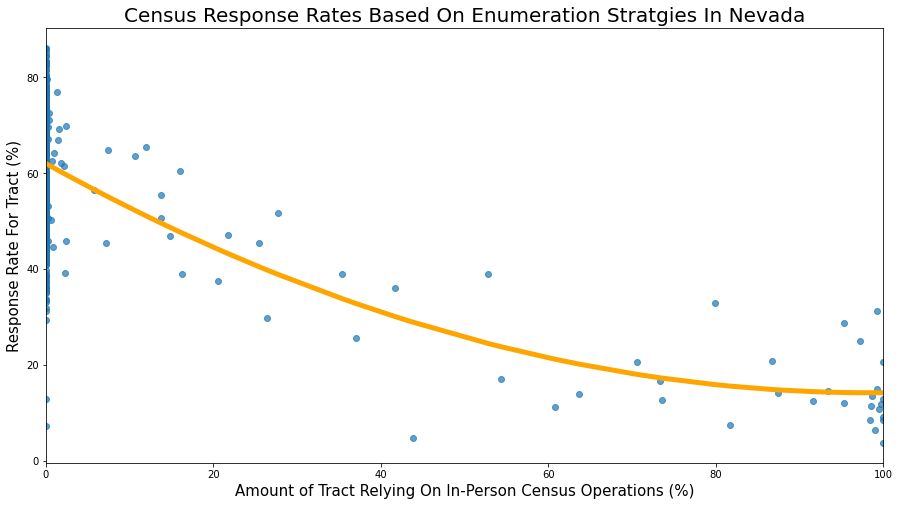

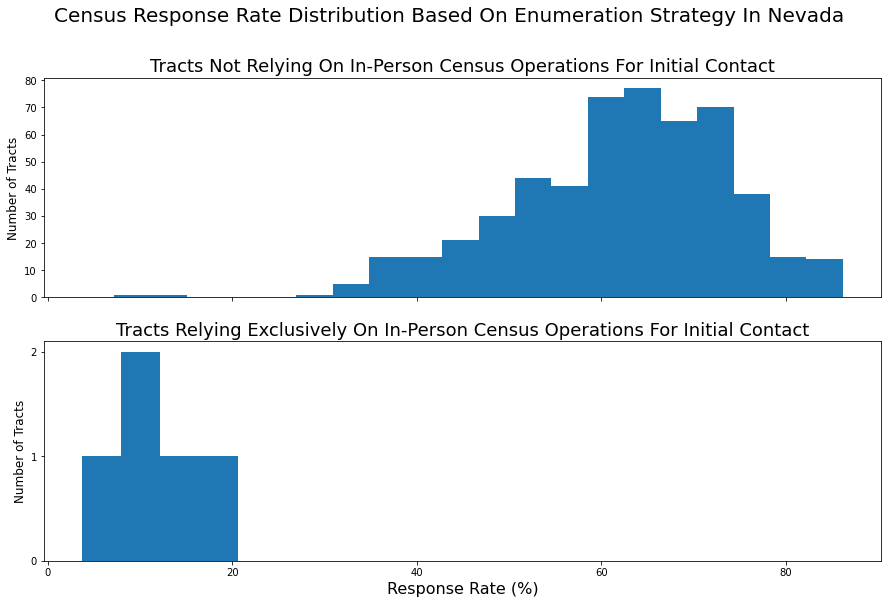

Correlation With Overall Response Rates In Nevada
Tracts Not Relying On In-Person Census Operatio...                                               0.66
Tracts Relying On In-Person Census Operations F...                                              -0.66

32003005612
32005001700
32005001800
32009950100
32031940200




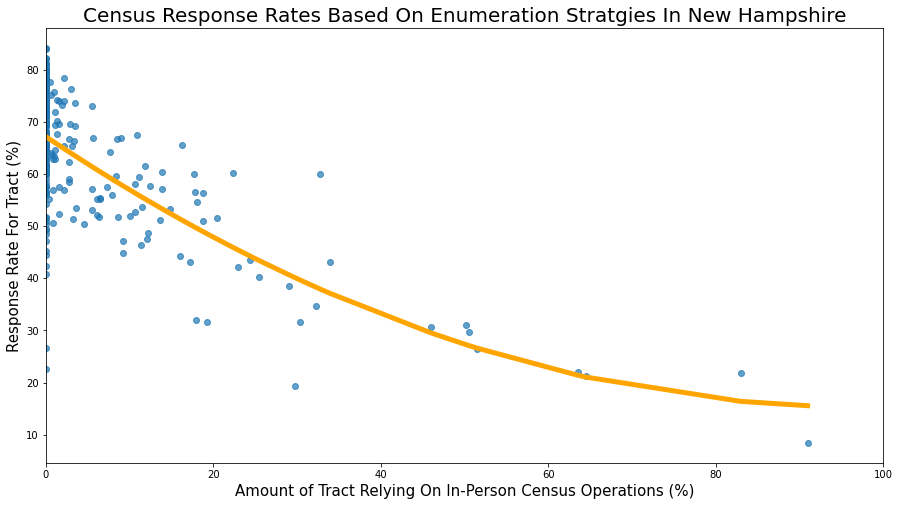

Correlation With Overall Response Rates In New Hampshire
Tracts Not Relying On In-Person Census Operatio...                                                0.7       
Tracts Relying On In-Person Census Operations F...                                               -0.7

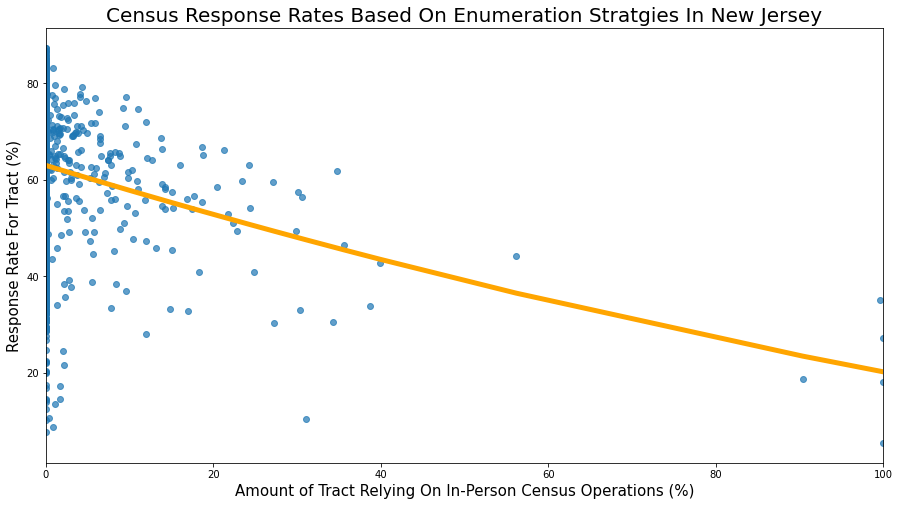

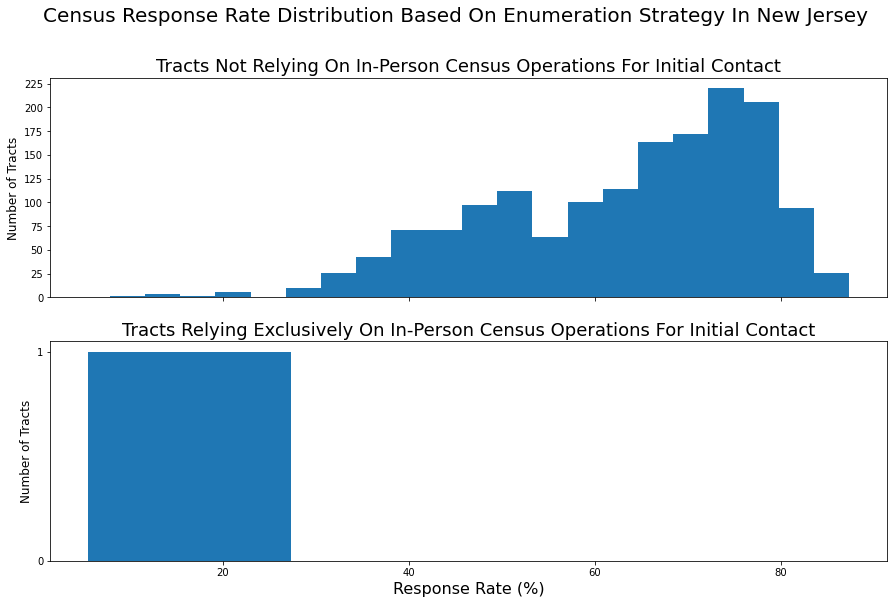

Correlation With Overall Response Rates In New Jersey
Tracts Not Relying On In-Person Census Operatio...                                                0.2    
Tracts Relying On In-Person Census Operations F...                                               -0.2

34005702101
34025809903
34029729000




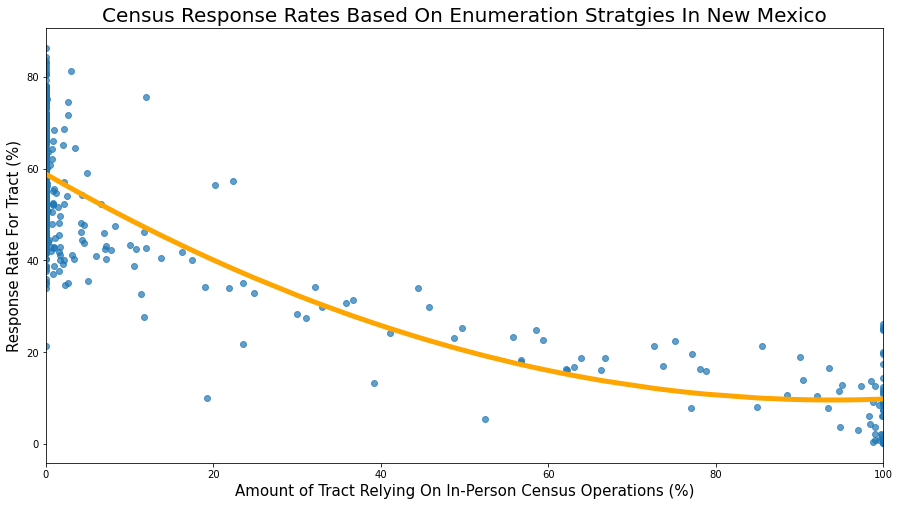

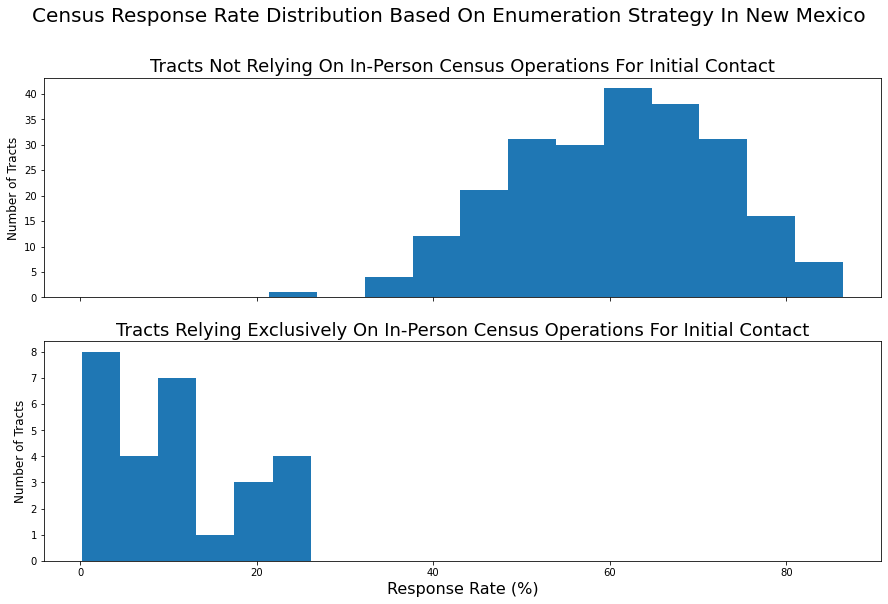

Correlation With Overall Response Rates In New Mexico
Tracts Not Relying On In-Person Census Operatio...                                               0.84    
Tracts Relying On In-Person Census Operations F...                                              -0.84

35001940700
35006941500
35006946100
35025000800
35031940500
35031943700
35031943800
35035940000
35039000100
35039940700
35039940800
35039944100
35043940500
35043940600
35043940700
35045942801
35045942802
35045942803
35045942900
35045943000
35045943100
35049940300
35049940500
35049940600
35049940900
35055940000
35061940300




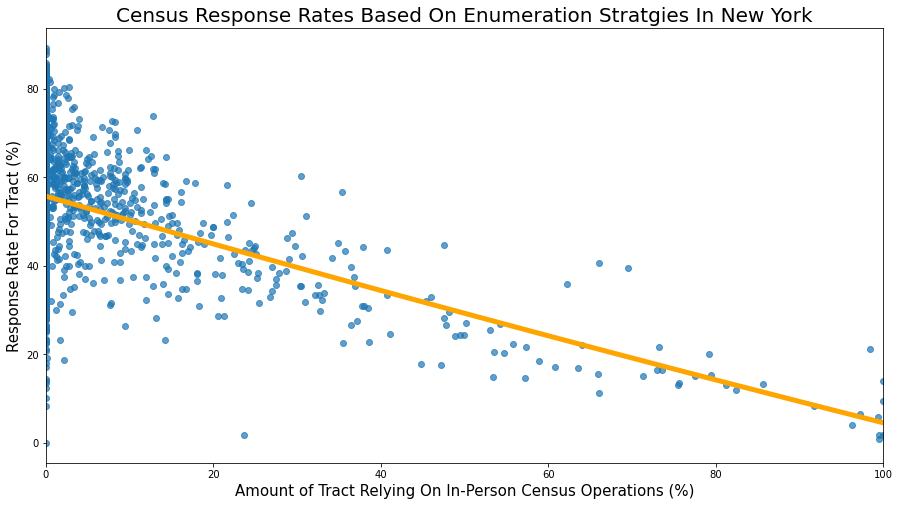

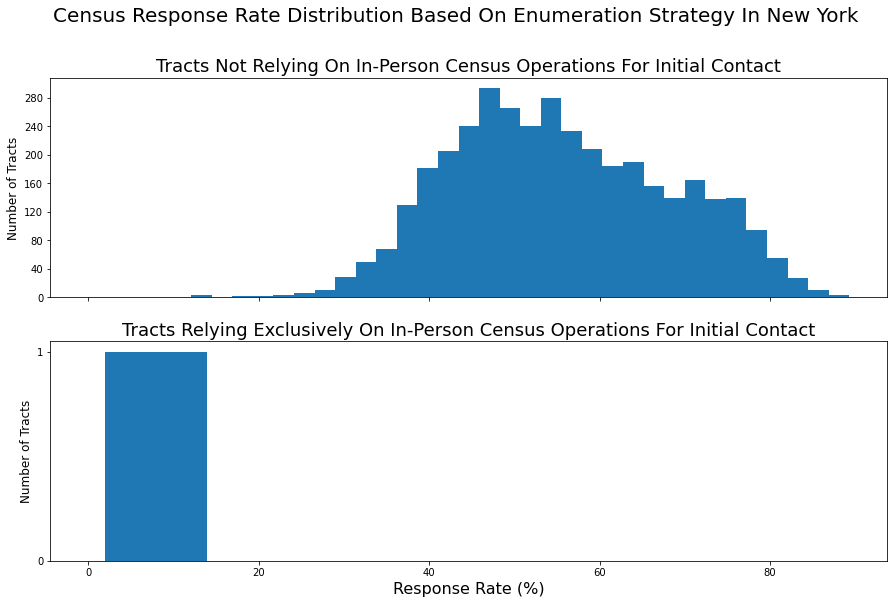

Correlation With Overall Response Rates In New York
Tracts Not Relying On In-Person Census Operatio...                                               0.34  
Tracts Relying On In-Person Census Operations F...                                              -0.34

36033940000
36067940000
36103180300




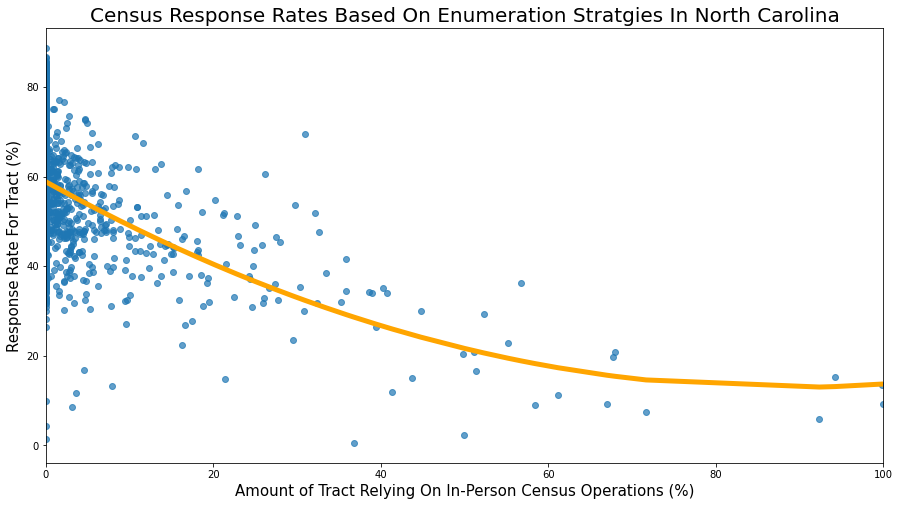

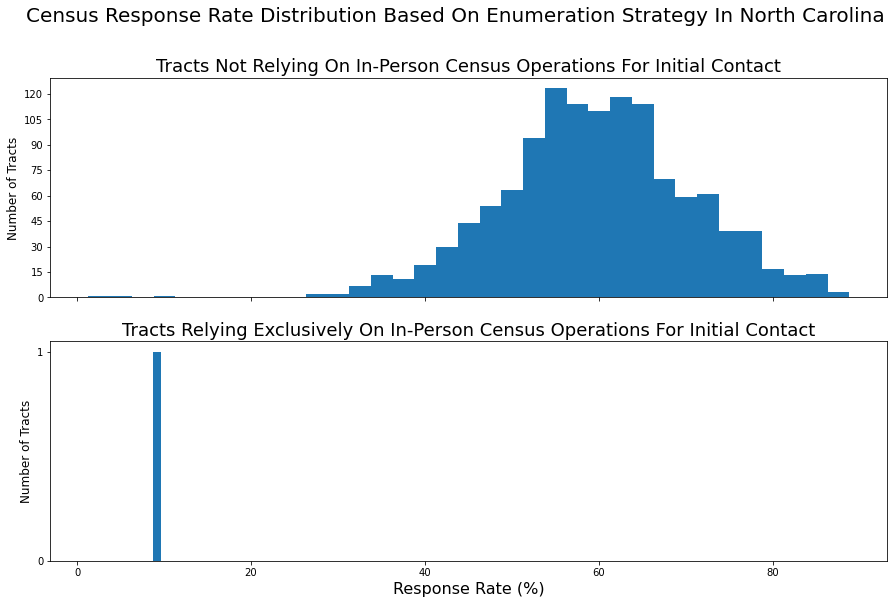

Correlation With Overall Response Rates In North Carolina
Tracts Not Relying On In-Person Census Operatio...                                               0.49        
Tracts Relying On In-Person Census Operations F...                                              -0.49

37133000800




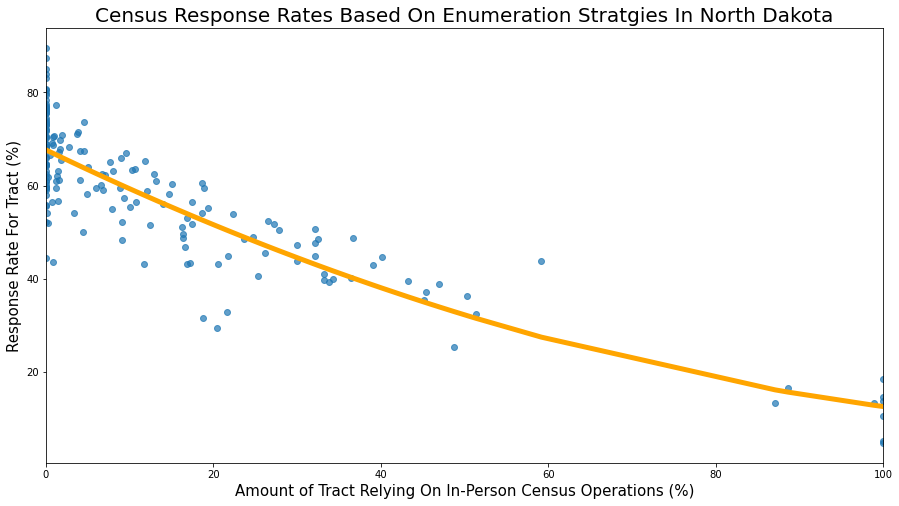

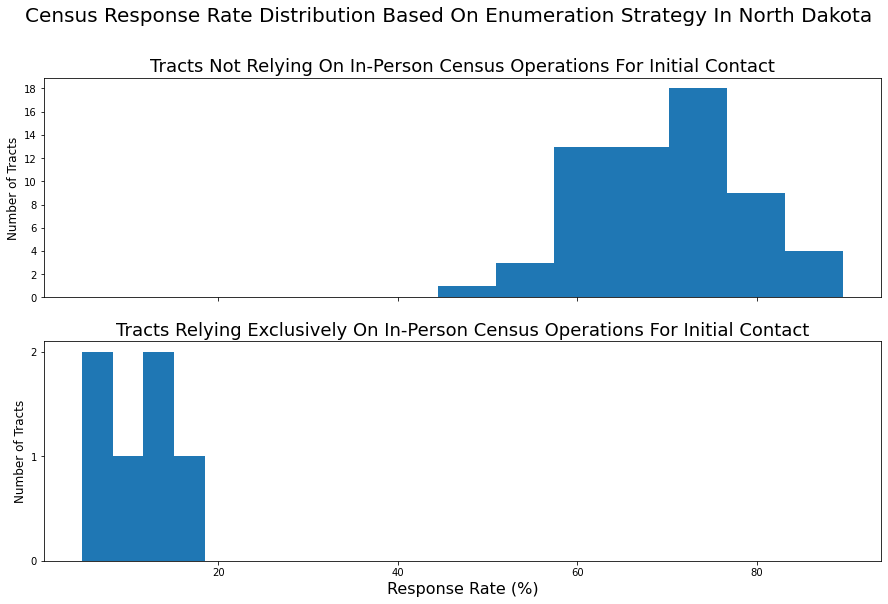

Correlation With Overall Response Rates In North Dakota
Tracts Not Relying On In-Person Census Operatio...                                               0.86      
Tracts Relying On In-Person Census Operations F...                                              -0.86

38053940100
38061940300
38061940400
38079941800
38085940800
38085940900




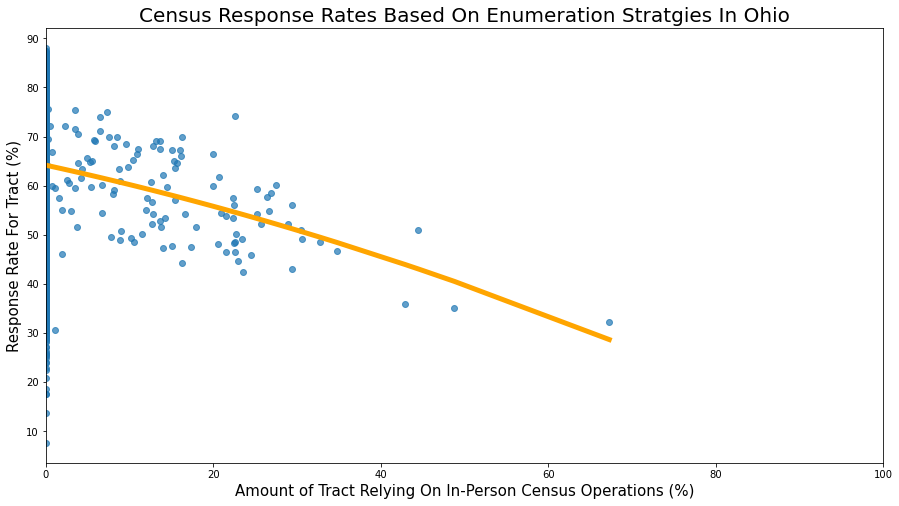

Correlation With Overall Response Rates In Ohio
Tracts Not Relying On In-Person Census Operatio...                                             0.13
Tracts Relying On In-Person Census Operations F...                                            -0.13

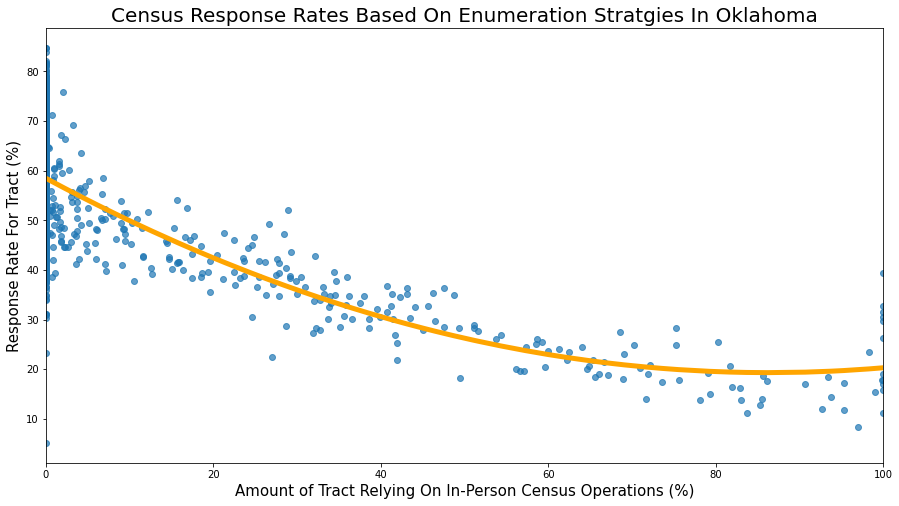

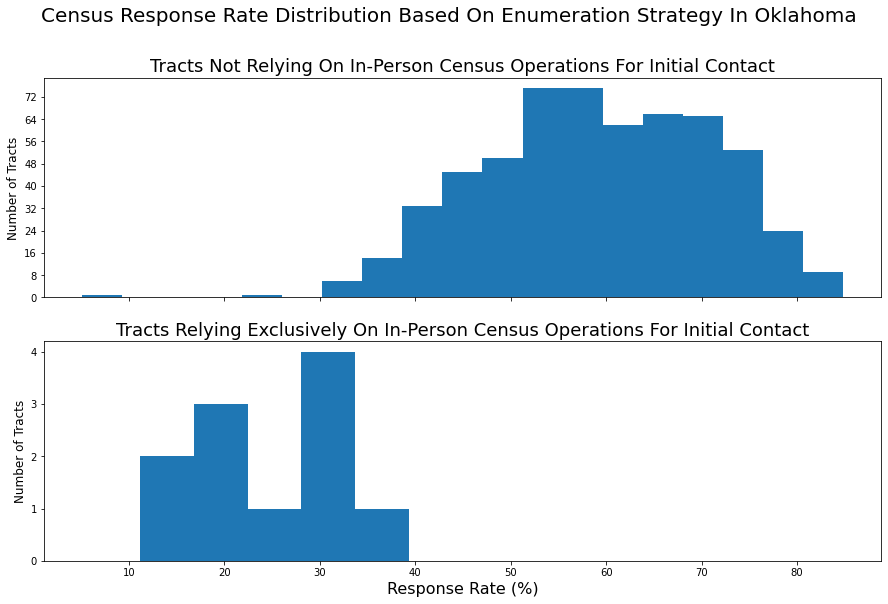

Correlation With Overall Response Rates In Oklahoma
Tracts Not Relying On In-Person Census Operatio...                                               0.73  
Tracts Relying On In-Person Census Operations F...                                              -0.73

40007951700
40025950100
40113940001
40113940003
40113940004
40113940005
40113940006
40113940007
40113940008
40113940009
40113940011




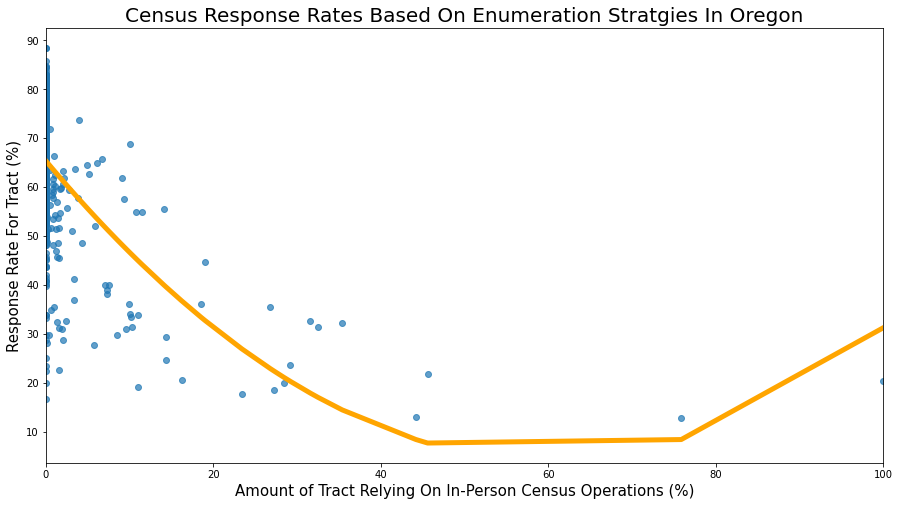

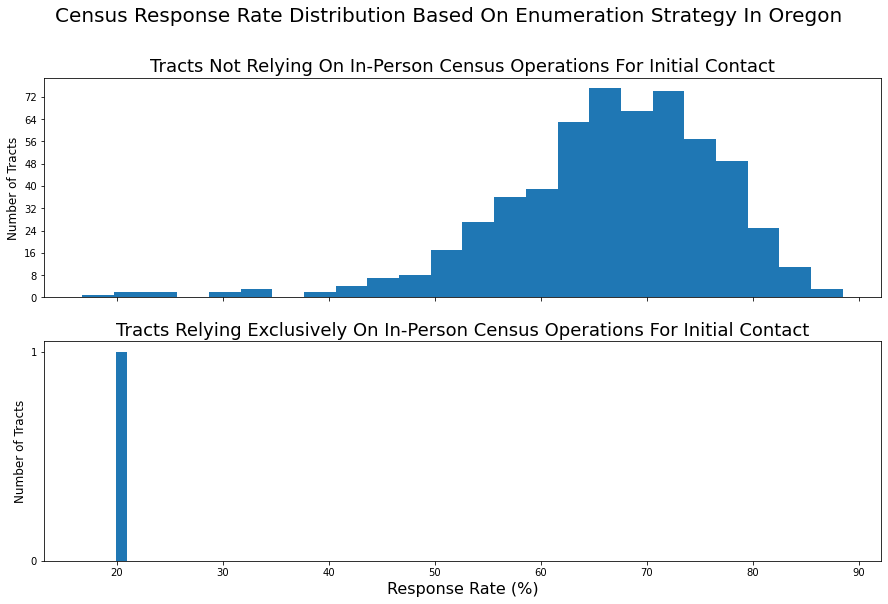

Correlation With Overall Response Rates In Oregon
Tracts Not Relying On In-Person Census Operatio...                                               0.47
Tracts Relying On In-Person Census Operations F...                                              -0.47

41031940000




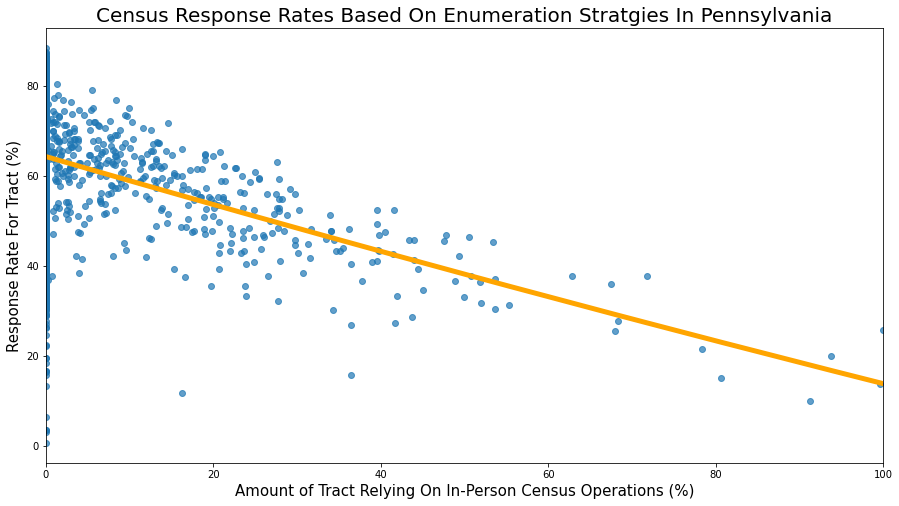

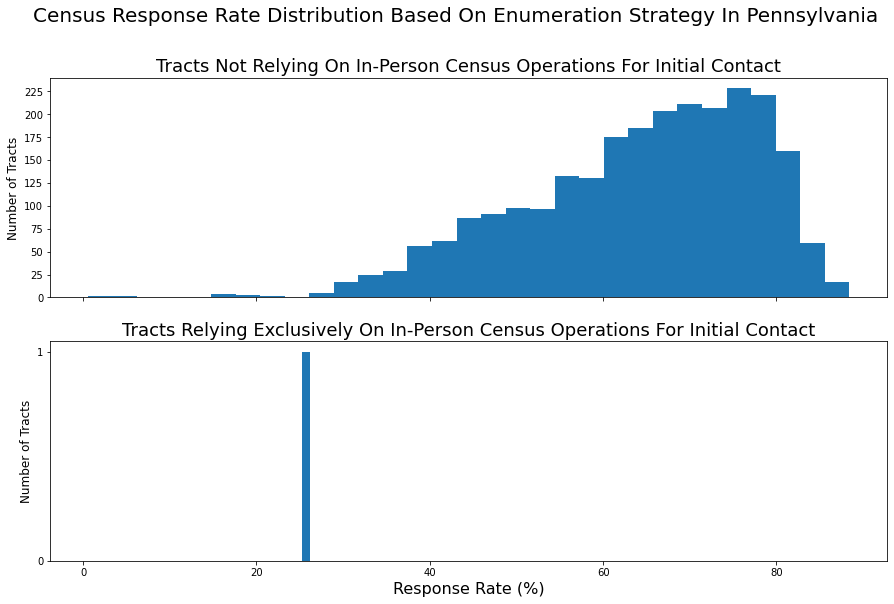

Correlation With Overall Response Rates In Pennsylvania
Tracts Not Relying On In-Person Census Operatio...                                               0.32      
Tracts Relying On In-Person Census Operations F...                                              -0.32

42079216501




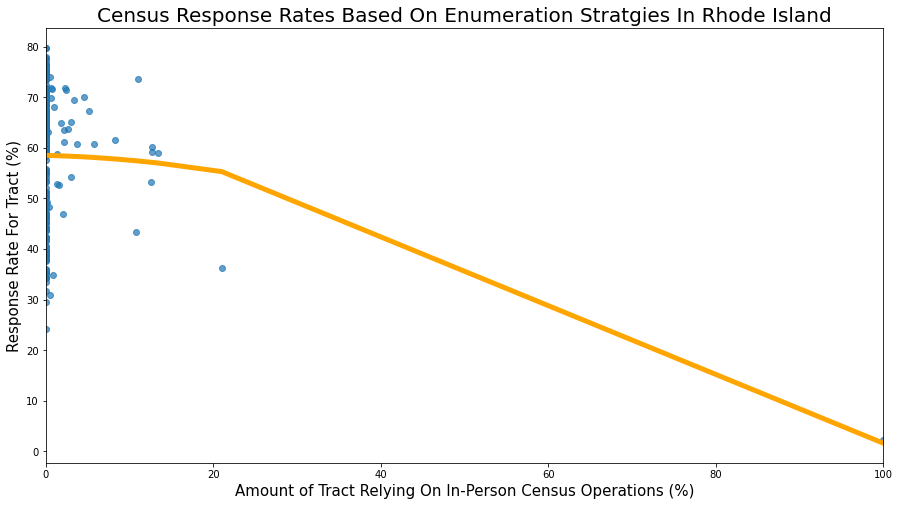

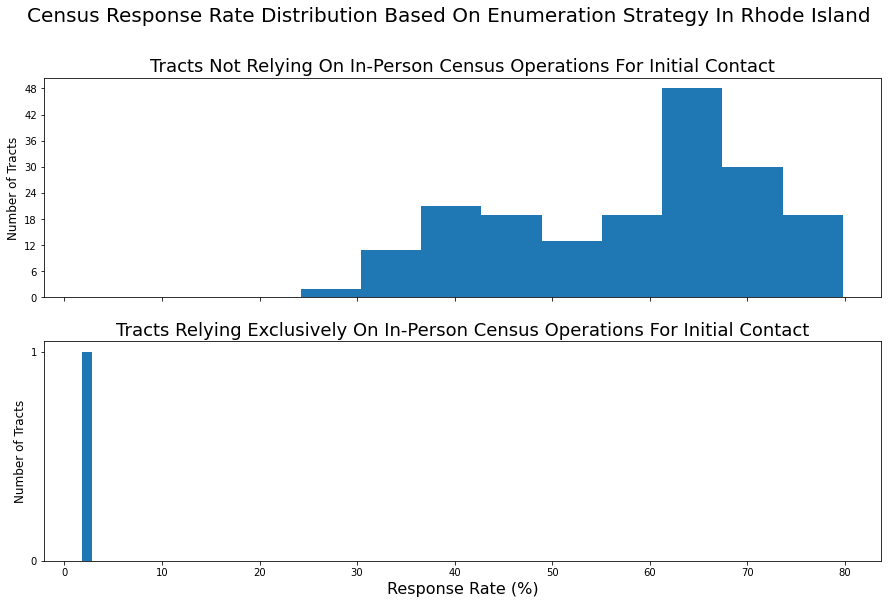

Correlation With Overall Response Rates In Rhode Island
Tracts Not Relying On In-Person Census Operatio...                                               0.28      
Tracts Relying On In-Person Census Operations F...                                              -0.28

44009041500




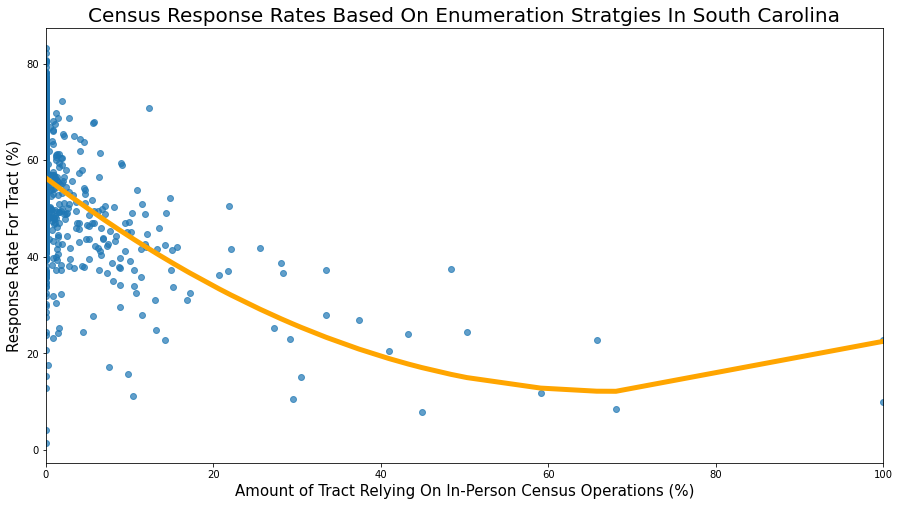

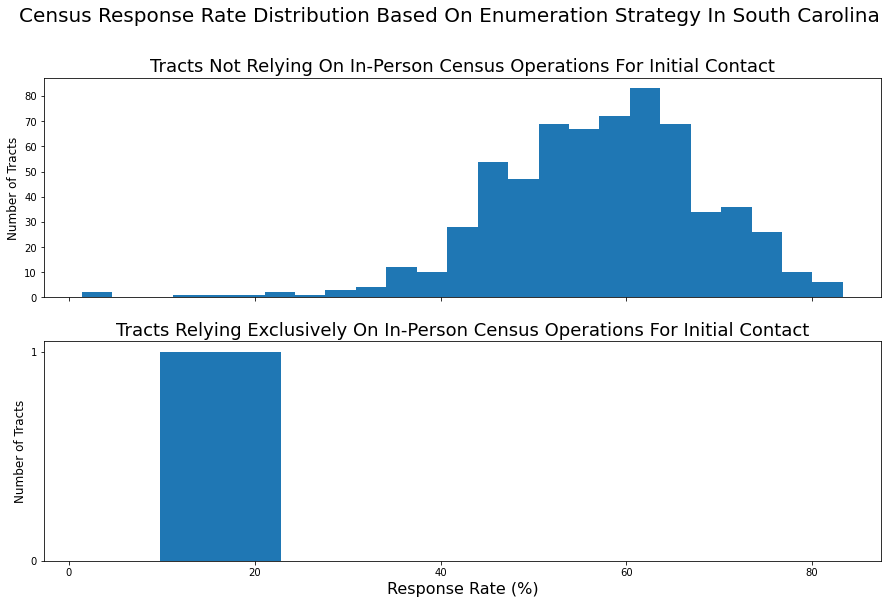

Correlation With Overall Response Rates In South Carolina
Tracts Not Relying On In-Person Census Operatio...                                               0.45        
Tracts Relying On In-Person Census Operations F...                                              -0.45

45019002004
45019003200




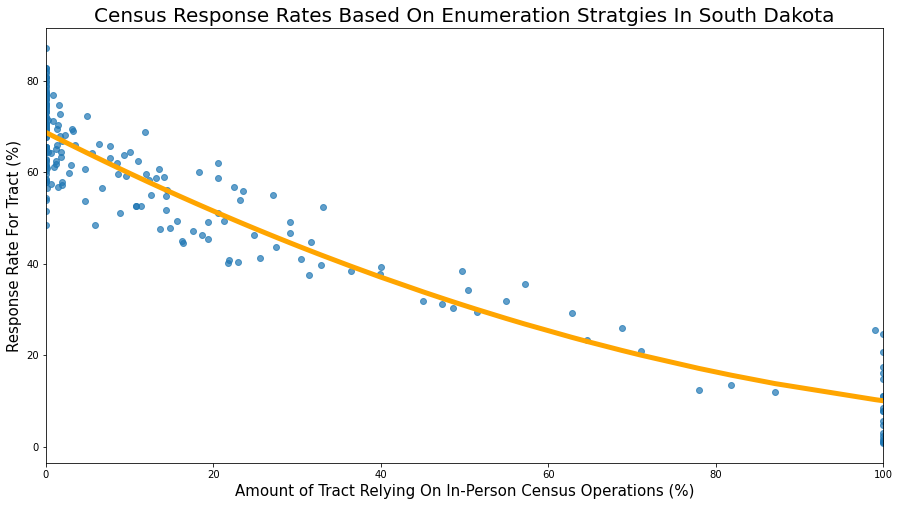

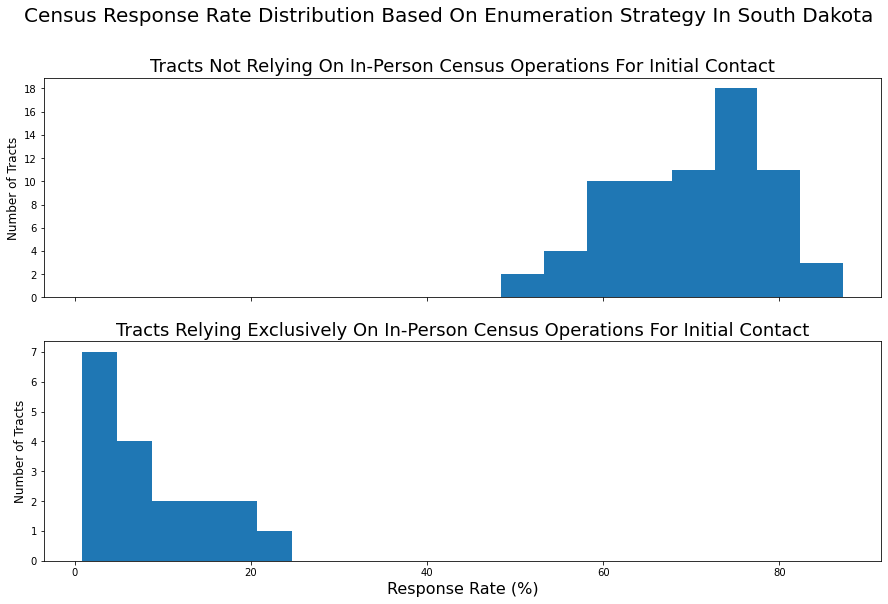

Correlation With Overall Response Rates In South Dakota
Tracts Not Relying On In-Person Census Operatio...                                               0.93      
Tracts Relying On In-Person Census Operations F...                                              -0.93

46007941000
46007941200
46023940200
46023940300
46031941000
46031941100
46041941500
46041941700
46071941200
46085940100
46102940500
46102940800
46102940900
46109940400
46109940800
46121940100
46121940200
46137941600




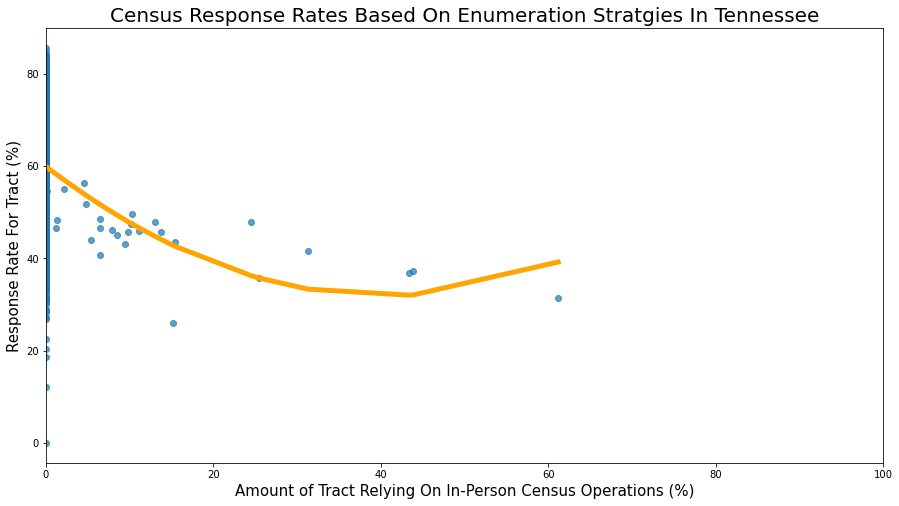

Correlation With Overall Response Rates In Tennessee
Tracts Not Relying On In-Person Census Operatio...                                               0.18   
Tracts Relying On In-Person Census Operations F...                                              -0.18

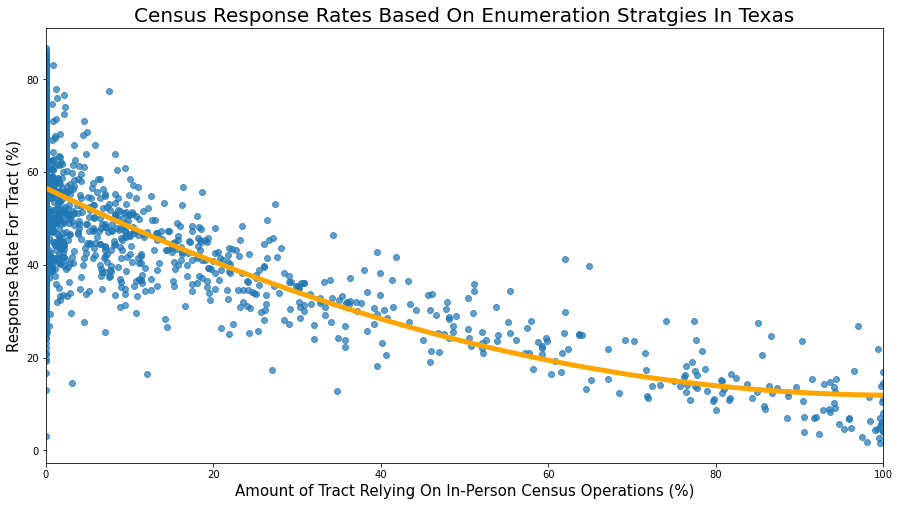

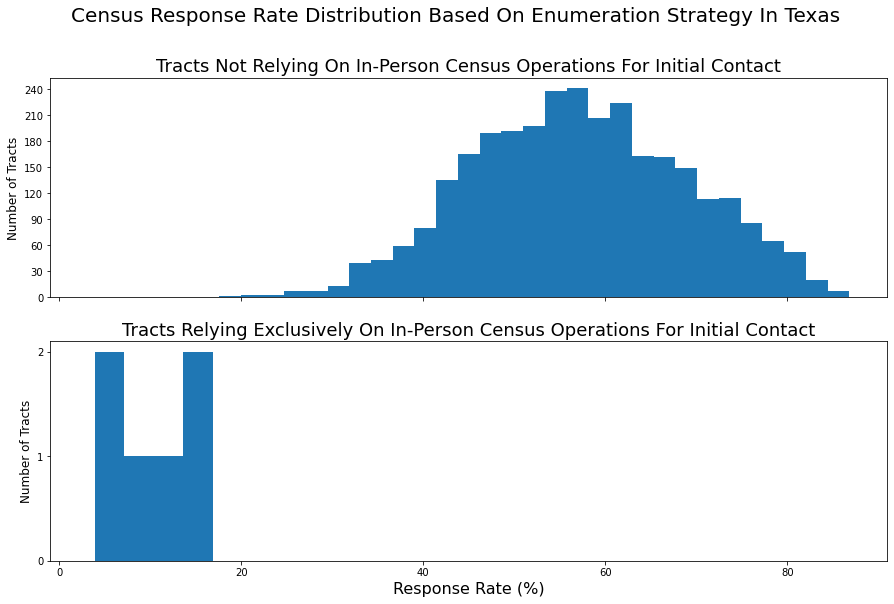

Correlation With Overall Response Rates In Texas
Tracts Not Relying On In-Person Census Operatio...                                              0.62
Tracts Relying On In-Person Census Operations F...                                             -0.62

48141010505
48141010506
48215024403
48409010500
48507950100
48507950200




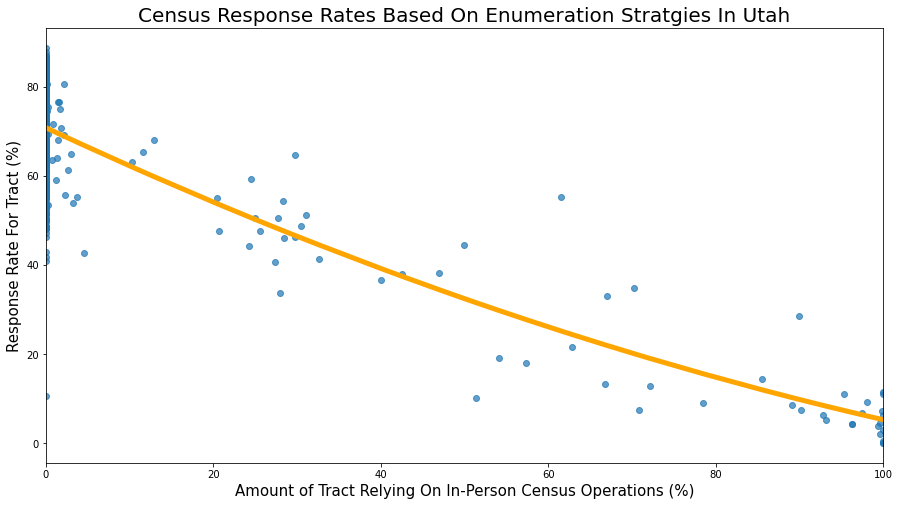

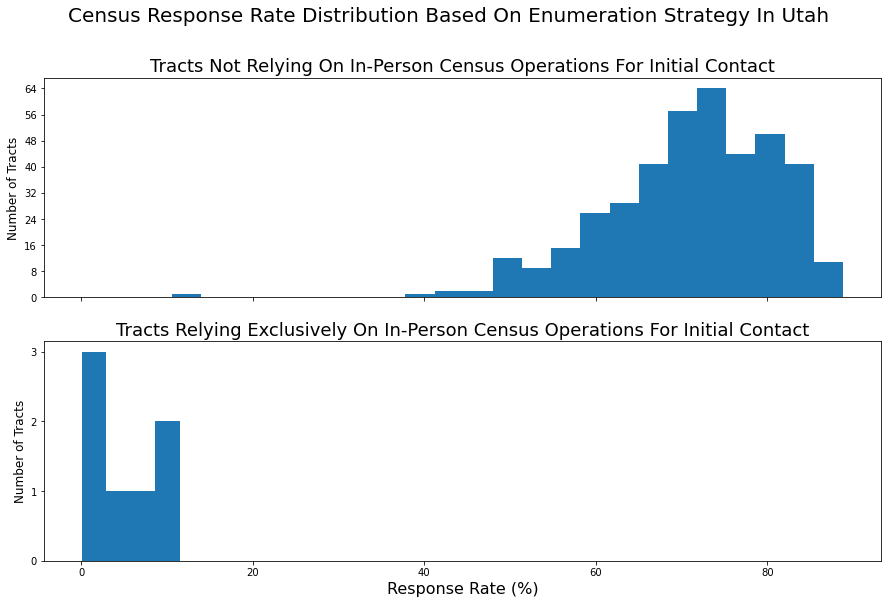

Correlation With Overall Response Rates In Utah
Tracts Not Relying On In-Person Census Operatio...                                             0.84
Tracts Relying On In-Person Census Operations F...                                            -0.84

49013940300
49013940600
49015976300
49037942000
49037942100
49043964203
49047940201




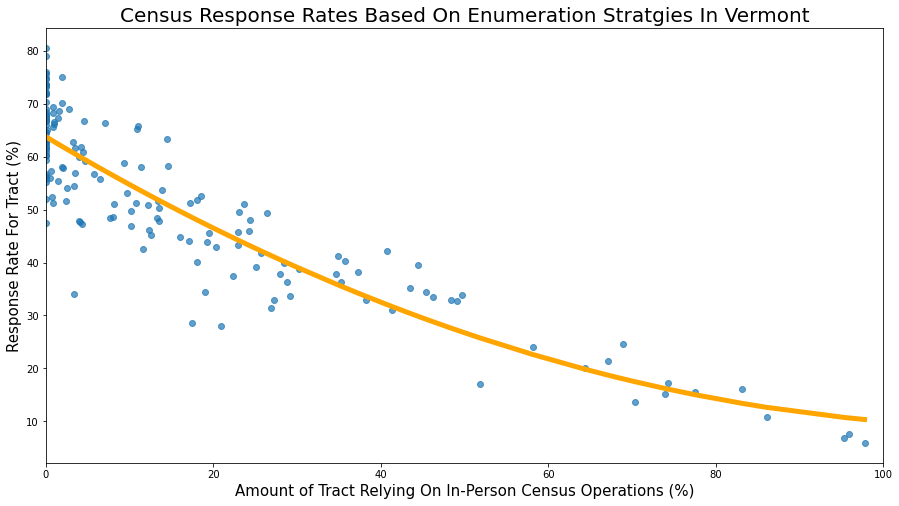

Correlation With Overall Response Rates In Vermont
Tracts Not Relying On In-Person Census Operatio...                                               0.89 
Tracts Relying On In-Person Census Operations F...                                              -0.89

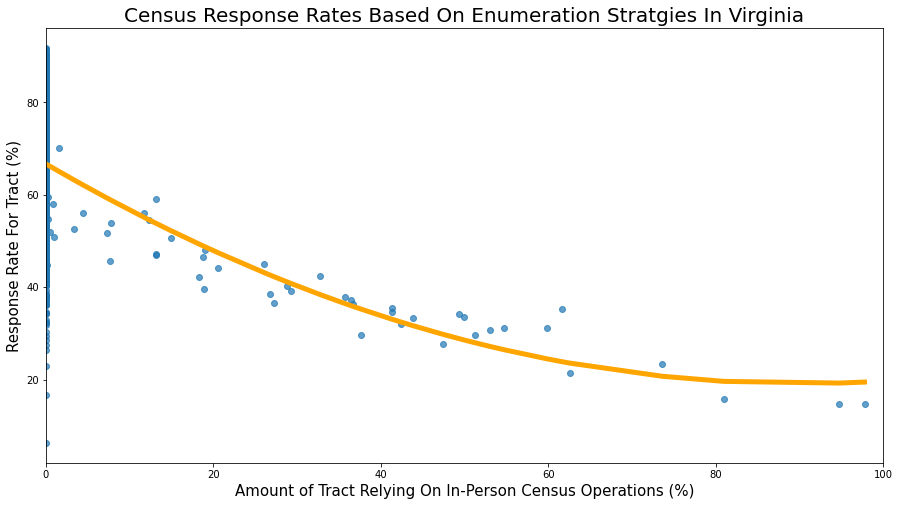

Correlation With Overall Response Rates In Virginia
Tracts Not Relying On In-Person Census Operatio...                                               0.36  
Tracts Relying On In-Person Census Operations F...                                              -0.36

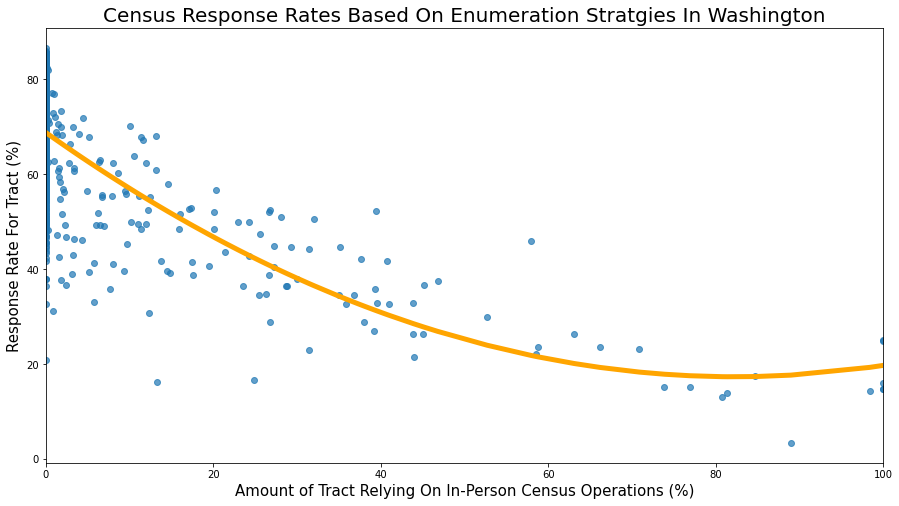

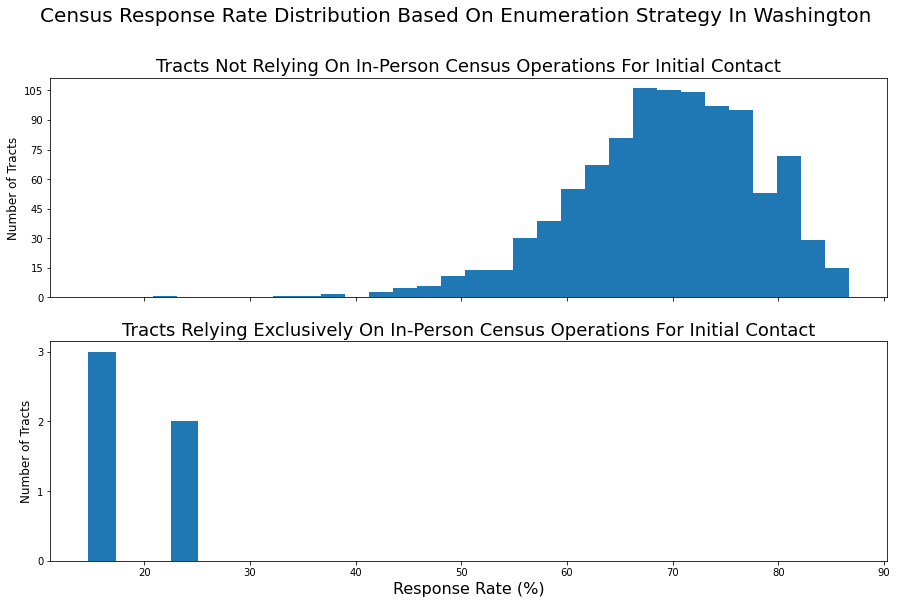

Correlation With Overall Response Rates In Washington
Tracts Not Relying On In-Person Census Operatio...                                               0.67    
Tracts Relying On In-Person Census Operations F...                                              -0.67

53019940000
53027940000
53047940100
53047940200
53065941000




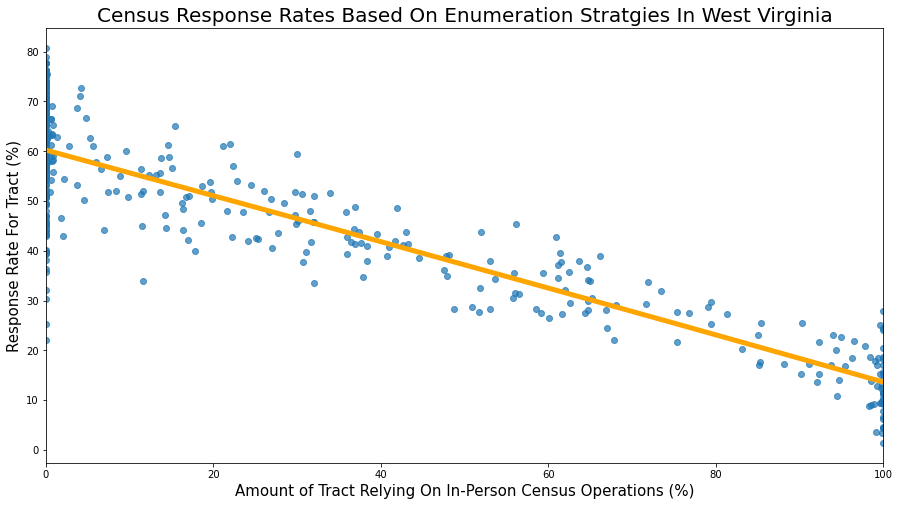

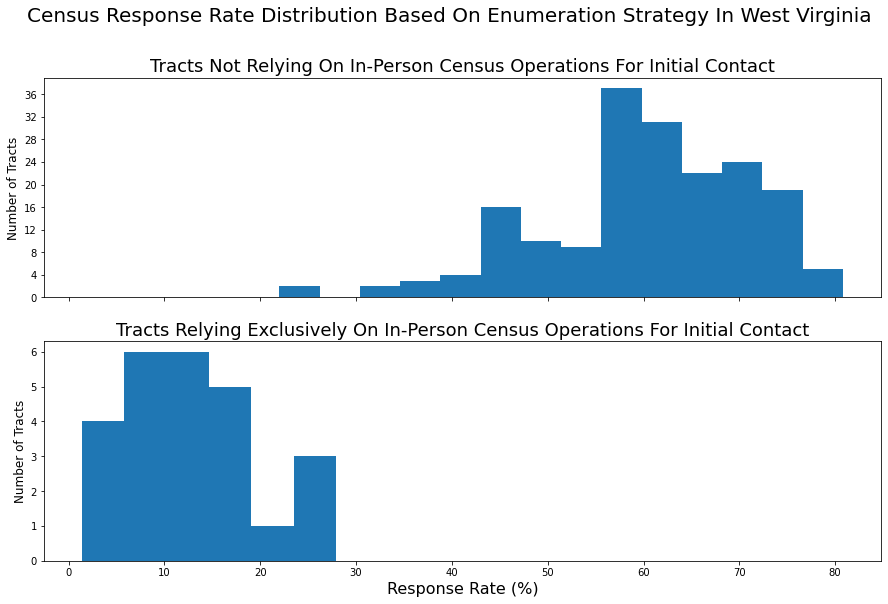

Correlation With Overall Response Rates In West Virginia
Tracts Not Relying On In-Person Census Operatio...                                               0.89       
Tracts Relying On In-Person Census Operations F...                                              -0.89

54019020500
54045956102
54045956500
54045956700
54045956800
54047953600
54047953800
54047953900
54047954200
54047954504
54057010100
54059957100
54059957200
54059957300
54059957700
54075960102
54081001002
54083966500
54089000600
54089000700
54089000800
54099020800
54109002800
54109002902
54109003100




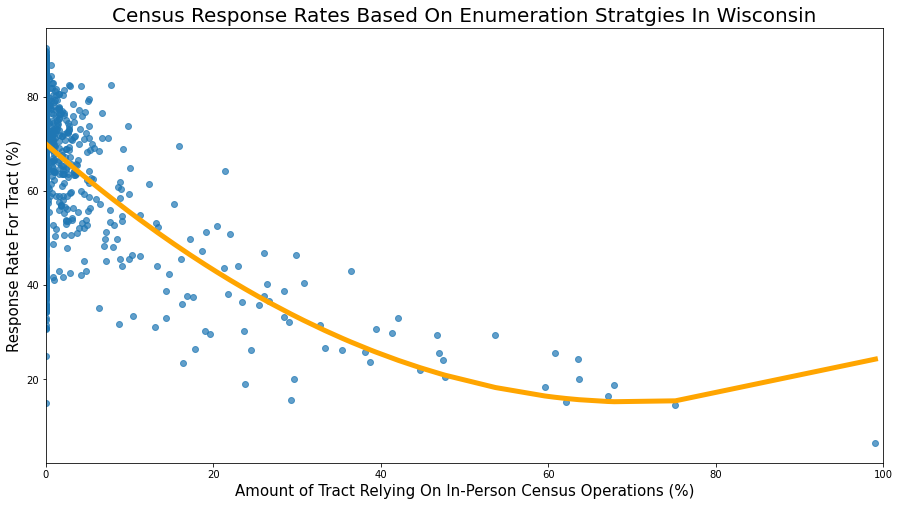

Correlation With Overall Response Rates In Wisconsin
Tracts Not Relying On In-Person Census Operatio...                                               0.54   
Tracts Relying On In-Person Census Operations F...                                              -0.54

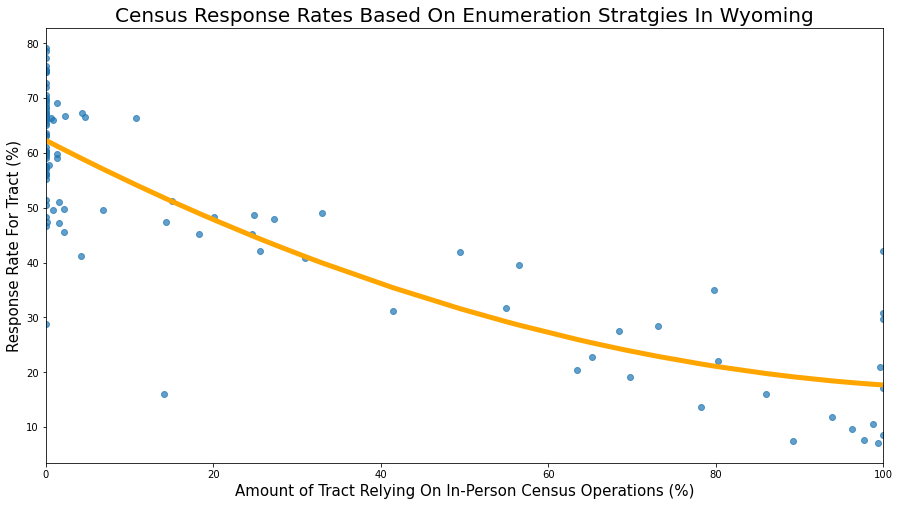

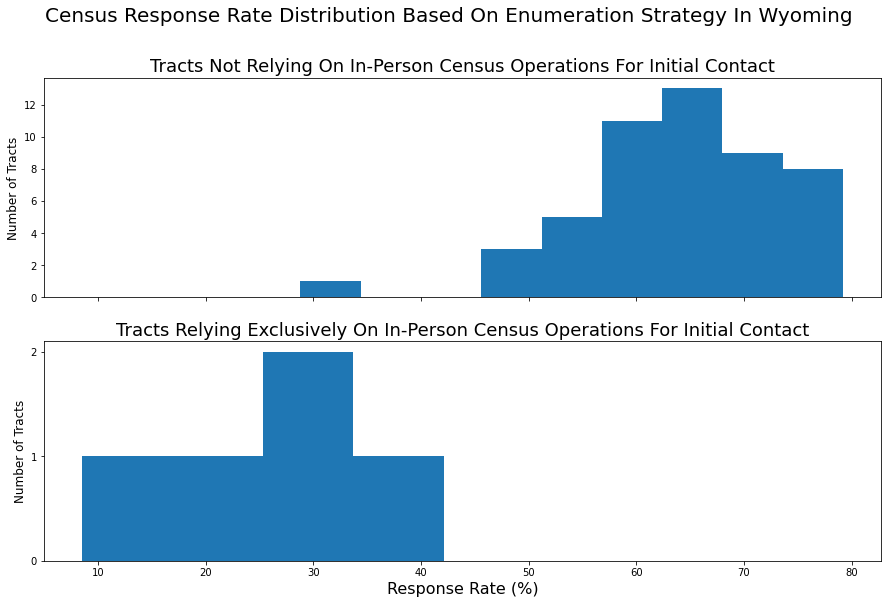

Correlation With Overall Response Rates In Wyoming
Tracts Not Relying On In-Person Census Operatio...                                               0.86 
Tracts Relying On In-Person Census Operations F...                                              -0.86

56013940100
56013940201
56013940202
56013940400
56013940500




In [178]:
# get names of areas to aid lookup in helper function below
names = pd.read_excel('https://www2.census.gov/programs-surveys/popest/geographies/2017/state-geocodes-v2017.xlsx',\
          skiprows=range(5),index_col=2).iloc[:,2]
names.columns=['name']

# add hyperlinks to each state
html = '<h2>Shortcut to state:</h2><p>'
links = sorted(names[names.index!=0])
for link in links:
    html += "<a href='#" + link + "'>" + link + "<br/></a>" 
html += '</p>'
display(HTML(html))

# helper function to plot individual areas
def show_area(fips):
    
    # convert to string
    area = str(fips)
    if len(area) == 1:
        area = area.zfill(2)
        
    # get name of area
    name = names[fips]
    
    # show name of area and add anchor
    display(HTML("<center><h1 id='" + name + "'>" + name +"</h1></center>"))
    
    # trim dataset to include only area in question
    new = data[data.index.str.startswith(area)]
    
    # if none of area relies on in-person enumeration, note and return
    if sum(new.inperson) == 0:
        display(HTML('<h4>' + name + ' does not rely on in-person enumeration</h4>'))
        return
    
    # generate separate datasets for areas with all in-person and no in-person enumeration  
    all_mail = new[new.inperson == 0]
    all_inperson = new[new.mail == 0]
    
    # generate list of tracts that rely completely on in-person enumeration
    tracts = sorted(all_inperson.index)
    
    # make scatterplot of data
    plt.figure(figsize=(15,8))
    plt.scatter(new.inperson,new.response,alpha=0.7,label='Areas Relying Heavily On In-Person Operations')
    plt.plot(np.unique(new.inperson),np.poly1d(np.polyfit(new.inperson,new.response, 2))(np.unique(new.inperson)),\
             c='orange',linewidth=5)
    plt.title('Census Response Rates Based On Enumeration Stratgies In ' + name,size=20)
    plt.xlim(0,100)
    plt.xlabel('Amount of Tract Relying On In-Person Census Operations (%)',size=15)
    plt.ylabel('Response Rate For Tract (%)',size=15)
    plt.show()

    if len(tracts) != 0:
        # make histogram of data
        fig,ax = plt.subplots(2,1,figsize=(15,9),sharex=True)
        plt.xlabel('Response Rate (%)',size=16)
        plt.subplots_adjust(top=0.87)
        plt.suptitle('Census Response Rate Distribution Based On Enumeration Strategy In ' + name,size=20)
        mai = ax[0]
        inp = ax[1]
        mai.yaxis.set_major_locator(MaxNLocator(integer=True))
        inp.yaxis.set_major_locator(MaxNLocator(integer=True))
        mai.set_ylabel('Number of Tracts',size=12)
        inp.set_ylabel('Number of Tracts',size=12)
        mai.hist(all_mail.response,bins='auto')
        inp.hist(all_inperson.response,bins='auto')
        mai.set_title('Tracts Not Relying On In-Person Census Operations For Initial Contact',size=18)
        inp.set_title('Tracts Relying Exclusively On In-Person Census Operations For Initial Contact',size=18)
        plt.show()

    # show correlations
    corrs = pd.DataFrame(new.corr().iloc[1:,0].round(2))
    corrs.columns = ['Correlation With Overall Response Rates In ' + name]
    corrs.index = ['Tracts Not Relying On In-Person Census Operations For Initial Contact',\
           'Tracts Relying On In-Person Census Operations For Initial Contact']
    display(corrs)
     
        # print total number of tracts examined
    display(HTML('<h4>Total number of tracts examined in ' + name + ': ' + str(new.shape[0]) + '</h4>'))
    
    # print FIPS codes of tracts that rely on in-person operations
    if len(tracts) == 0:
        display(HTML('<h4>No tracts in ' + name + ' rely entirely on in-person census operations for initial contact</h4>'))
    else:
        display(HTML('<h4>Tracts in ' + name + \
                ' that are known to rely entirely on in-person census operations for initial contact:</h4>'))
        for tract in tracts:
            print(tract)
    
    # add space
    print('\n')
    

# iterate through all states to display data
states_iter = names[names.index != 0].sort_values()
for place in states_iter.index:
    show_area(place)

# Adapting This Analysis For Your Newsroom

*NewsCounts* can help you run this analysis for your region. It is *very* easy for us to pop out these same numbers for just about any level of US geography with a FIPS code, as long as it has a reasonable mass of tracts relying on in-person enumeration.

We can do it almost instantaneously - just ask!

### Contact Info & Other Resources

Feel free to email me at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) any time if you'd like us to do this for your area.

The Census Bureau is tracking 2020 response rates and provides [a wonderful map with up-to-date data](https://2020census.gov/en/response-rates.html). *NewsCounts* also provides a [beta dashboard](https://newscounts.appspot.com/) and [API](https://bernacho.github.io/NewsCounts-ResponseRatesAPI/API_documentation.html) that allows you to grab the daily response data for yourself. 

We have also conducted a couple other analyses that you may find useful for local census reporting:
* [The Demographics Of Census Nonresponses In Your Region](https://bwliv.github.io/undercount_modeling)
* [A Guide To Using Congressional Apportionment Data In Census News Stories](https://bwliv.github.io/apportionment)

Please don't hesistate to reach out with any census reporting-related questions. We recognize 2020 is a challenging time for journalists, and we're here to make covering this pivotal census easier for you.